# Deep cortical machine learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.3793673721102073 -2.799938337493372
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [19]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [20]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [21]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [22]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * targetQs[1:])
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                     labels=reward*tf.ones_like(Qs_logits)))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits[:-1],
                                                                     labels=tf.reshape(tf.nn.sigmoid(targetQs[1:]),
                                                                                       shape=[-1, 1])))
    d_loss = d_lossR + d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [23]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [24]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [25]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [26]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [27]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [28]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [29]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(11111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ),
)
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
#         # Break episode/epoch loop
#         if np.mean(episodes_total_reward) >= 500:
#             break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:10.0000 gloss:0.1380 dloss:1.5025 dlossR:0.8204 dlossQ:0.6821
Episode:1 meanR:10.0000 gloss:0.0750 dloss:1.4550 dlossR:0.7662 dlossQ:0.6888
Episode:2 meanR:10.0000 gloss:0.0214 dloss:1.4089 dlossR:0.7165 dlossQ:0.6924
Episode:3 meanR:9.7500 gloss:-0.0279 dloss:1.3597 dlossR:0.6670 dlossQ:0.6928
Episode:4 meanR:9.6000 gloss:-0.0690 dloss:1.3165 dlossR:0.6264 dlossQ:0.6902
Episode:5 meanR:9.3333 gloss:-0.1063 dloss:1.2837 dlossR:0.5973 dlossQ:0.6864
Episode:6 meanR:9.2857 gloss:-0.1398 dloss:1.2420 dlossR:0.5625 dlossQ:0.6795
Episode:7 meanR:9.3750 gloss:-0.1741 dloss:1.1993 dlossR:0.5291 dlossQ:0.6702
Episode:8 meanR:9.4444 gloss:-0.2075 dloss:1.1667 dlossR:0.5049 dlossQ:0.6618
Episode:9 meanR:9.5000 gloss:-0.2497 dloss:1.1281 dlossR:0.4777 dlossQ:0.6503
Episode:10 meanR:9.5455 gloss:0.1909 dloss:1.5626 dlossR:0.9001 dlossQ:0.6625
Episode:11 meanR:9.5833 gloss:0.1610 dloss:1.5429 dlossR:0.8762 dlossQ:0.6667
Episode:12 meanR:9.5385 gloss:0.1327 dloss:1.5184 dlossR:0.8455 

Episode:104 meanR:22.8200 gloss:-2.0103 dloss:0.5728 dlossR:0.3681 dlossQ:0.2046
Episode:105 meanR:23.0800 gloss:-2.0190 dloss:0.4541 dlossR:0.2515 dlossQ:0.2026
Episode:106 meanR:23.4900 gloss:-2.0240 dloss:0.5469 dlossR:0.3453 dlossQ:0.2016
Episode:107 meanR:24.0900 gloss:-2.0557 dloss:0.6630 dlossR:0.4666 dlossQ:0.1964
Episode:108 meanR:24.3900 gloss:-2.0417 dloss:0.4865 dlossR:0.2877 dlossQ:0.1988
Episode:109 meanR:24.5900 gloss:-2.0816 dloss:0.4220 dlossR:0.2298 dlossQ:0.1922
Episode:110 meanR:24.8800 gloss:-2.0548 dloss:0.4795 dlossR:0.2826 dlossQ:0.1969
Episode:111 meanR:25.0200 gloss:-2.0879 dloss:0.3880 dlossR:0.1948 dlossQ:0.1932
Episode:112 meanR:25.1900 gloss:-2.0981 dloss:0.3978 dlossR:0.2068 dlossQ:0.1910
Episode:113 meanR:25.2900 gloss:-2.3946 dloss:0.3314 dlossR:0.1777 dlossQ:0.1536
Episode:114 meanR:25.7700 gloss:-1.9908 dloss:0.5860 dlossR:0.3773 dlossQ:0.2087
Episode:115 meanR:26.0500 gloss:-1.9753 dloss:0.4791 dlossR:0.2674 dlossQ:0.2117
Episode:116 meanR:26.1800 gl

Episode:208 meanR:34.6100 gloss:-1.6229 dloss:0.5896 dlossR:0.2932 dlossQ:0.2964
Episode:209 meanR:34.6500 gloss:-1.6179 dloss:0.5490 dlossR:0.2512 dlossQ:0.2978
Episode:210 meanR:34.5700 gloss:-1.6191 dloss:0.5345 dlossR:0.2371 dlossQ:0.2974
Episode:211 meanR:34.6900 gloss:-1.6346 dloss:0.5535 dlossR:0.2602 dlossQ:0.2933
Episode:212 meanR:34.7300 gloss:-1.6385 dloss:0.5236 dlossR:0.2317 dlossQ:0.2919
Episode:213 meanR:34.8900 gloss:-1.6483 dloss:0.5497 dlossR:0.2600 dlossQ:0.2897
Episode:214 meanR:34.5900 gloss:-1.6599 dloss:0.4978 dlossR:0.2118 dlossQ:0.2860
Episode:215 meanR:34.5800 gloss:-1.6760 dloss:0.5423 dlossR:0.2596 dlossQ:0.2827
Episode:216 meanR:34.5400 gloss:-1.7049 dloss:0.4493 dlossR:0.1755 dlossQ:0.2738
Episode:217 meanR:34.7000 gloss:-1.7003 dloss:0.5503 dlossR:0.2742 dlossQ:0.2761
Episode:218 meanR:34.8400 gloss:-1.7170 dloss:0.5013 dlossR:0.2295 dlossQ:0.2718
Episode:219 meanR:35.0700 gloss:-1.7653 dloss:0.5038 dlossR:0.2440 dlossQ:0.2597
Episode:220 meanR:34.8900 gl

Episode:316 meanR:33.8900 gloss:-1.9355 dloss:0.3693 dlossR:0.1413 dlossQ:0.2280
Episode:317 meanR:34.6600 gloss:-1.3538 dloss:0.9626 dlossR:0.5866 dlossQ:0.3759
Episode:318 meanR:35.3700 gloss:-1.3711 dloss:0.9009 dlossR:0.5301 dlossQ:0.3708
Episode:319 meanR:35.8100 gloss:-1.3830 dloss:0.8029 dlossR:0.4358 dlossQ:0.3672
Episode:320 meanR:36.2400 gloss:-1.3891 dloss:0.7975 dlossR:0.4321 dlossQ:0.3654
Episode:321 meanR:36.5000 gloss:-1.4879 dloss:0.6247 dlossR:0.2881 dlossQ:0.3366
Episode:322 meanR:36.5400 gloss:-1.4727 dloss:0.6255 dlossR:0.2843 dlossQ:0.3411
Episode:323 meanR:37.0600 gloss:-1.4050 dloss:0.7529 dlossR:0.3922 dlossQ:0.3607
Episode:324 meanR:37.4700 gloss:-1.4165 dloss:0.7049 dlossR:0.3476 dlossQ:0.3573
Episode:325 meanR:37.7900 gloss:-1.4345 dloss:0.6710 dlossR:0.3188 dlossQ:0.3522
Episode:326 meanR:37.9600 gloss:-1.4298 dloss:0.6061 dlossR:0.2529 dlossQ:0.3532
Episode:327 meanR:38.2300 gloss:-1.4272 dloss:0.6356 dlossR:0.2817 dlossQ:0.3539
Episode:328 meanR:38.7800 gl

Episode:423 meanR:44.1000 gloss:-1.5979 dloss:0.4676 dlossR:0.1627 dlossQ:0.3049
Episode:424 meanR:43.6600 gloss:-1.6256 dloss:0.4453 dlossR:0.1478 dlossQ:0.2975
Episode:425 meanR:43.2700 gloss:-1.6987 dloss:0.4143 dlossR:0.1343 dlossQ:0.2800
Episode:426 meanR:43.0500 gloss:-1.7622 dloss:0.3994 dlossR:0.1343 dlossQ:0.2651
Episode:427 meanR:42.7700 gloss:-1.8309 dloss:0.3846 dlossR:0.1349 dlossQ:0.2498
Episode:428 meanR:42.1900 gloss:-1.8920 dloss:0.3690 dlossR:0.1297 dlossQ:0.2393
Episode:429 meanR:41.6100 gloss:-1.8228 dloss:0.3806 dlossR:0.1272 dlossQ:0.2533
Episode:430 meanR:41.4800 gloss:-1.7917 dloss:0.3806 dlossR:0.1222 dlossQ:0.2584
Episode:431 meanR:42.0300 gloss:-1.4834 dloss:0.9081 dlossR:0.5704 dlossQ:0.3378
Episode:432 meanR:42.5100 gloss:-1.4637 dloss:0.8460 dlossR:0.5012 dlossQ:0.3449
Episode:433 meanR:43.2000 gloss:-1.4534 dloss:0.9411 dlossR:0.5930 dlossQ:0.3482
Episode:434 meanR:43.8100 gloss:-1.3934 dloss:0.8837 dlossR:0.5204 dlossQ:0.3633
Episode:435 meanR:43.9600 gl

Episode:531 meanR:47.0300 gloss:-1.5822 dloss:0.5152 dlossR:0.2013 dlossQ:0.3140
Episode:532 meanR:46.2500 gloss:-1.9938 dloss:0.3573 dlossR:0.1393 dlossQ:0.2180
Episode:533 meanR:45.7100 gloss:-1.3010 dloss:0.7647 dlossR:0.3693 dlossQ:0.3954
Episode:534 meanR:45.4700 gloss:-1.3386 dloss:0.8102 dlossR:0.4260 dlossQ:0.3842
Episode:535 meanR:45.1100 gloss:-1.5088 dloss:0.5799 dlossR:0.2489 dlossQ:0.3310
Episode:536 meanR:44.6100 gloss:-1.5021 dloss:0.4891 dlossR:0.1579 dlossQ:0.3311
Episode:537 meanR:44.2400 gloss:-1.4983 dloss:0.5306 dlossR:0.1971 dlossQ:0.3335
Episode:538 meanR:43.5400 gloss:-1.5201 dloss:0.4862 dlossR:0.1601 dlossQ:0.3260
Episode:539 meanR:43.4900 gloss:-1.8698 dloss:0.5861 dlossR:0.3172 dlossQ:0.2689
Episode:540 meanR:43.6400 gloss:-1.5412 dloss:0.6001 dlossR:0.2782 dlossQ:0.3220
Episode:541 meanR:43.9000 gloss:-1.5794 dloss:0.6245 dlossR:0.3134 dlossQ:0.3111
Episode:542 meanR:44.1300 gloss:-1.6059 dloss:0.6132 dlossR:0.3091 dlossQ:0.3041
Episode:543 meanR:45.0000 gl

Episode:634 meanR:43.9500 gloss:-1.4649 dloss:0.6014 dlossR:0.2584 dlossQ:0.3430
Episode:635 meanR:44.1400 gloss:-1.4314 dloss:0.6836 dlossR:0.3307 dlossQ:0.3529
Episode:636 meanR:44.6000 gloss:-1.4189 dloss:0.7124 dlossR:0.3557 dlossQ:0.3567
Episode:637 meanR:44.7900 gloss:-1.4316 dloss:0.6360 dlossR:0.2824 dlossQ:0.3536
Episode:638 meanR:49.6700 gloss:-1.3159 dloss:2.4261 dlossR:2.0389 dlossQ:0.3872
Episode:639 meanR:49.7400 gloss:-1.3834 dloss:0.6968 dlossR:0.3290 dlossQ:0.3679
Episode:640 meanR:51.2000 gloss:-1.2204 dloss:1.2288 dlossR:0.8111 dlossQ:0.4177
Episode:641 meanR:51.4800 gloss:-1.0966 dloss:0.8840 dlossR:0.4259 dlossQ:0.4581
Episode:642 meanR:51.9300 gloss:-1.1926 dloss:0.9051 dlossR:0.4787 dlossQ:0.4264
Episode:643 meanR:51.4500 gloss:-1.1501 dloss:0.8019 dlossR:0.3615 dlossQ:0.4404
Episode:644 meanR:51.5100 gloss:-1.1850 dloss:0.7545 dlossR:0.3250 dlossQ:0.4295
Episode:645 meanR:50.3200 gloss:-1.1639 dloss:0.6820 dlossR:0.2459 dlossQ:0.4361
Episode:646 meanR:49.2100 gl

Episode:740 meanR:30.2600 gloss:-1.7171 dloss:0.8118 dlossR:0.5374 dlossQ:0.2744
Episode:741 meanR:29.6200 gloss:-2.2692 dloss:0.2792 dlossR:0.1154 dlossQ:0.1638
Episode:742 meanR:29.3200 gloss:-1.8096 dloss:0.6501 dlossR:0.3940 dlossQ:0.2560
Episode:743 meanR:29.4200 gloss:-1.7753 dloss:0.6758 dlossR:0.4142 dlossQ:0.2615
Episode:744 meanR:29.4700 gloss:-1.7374 dloss:0.6073 dlossR:0.3361 dlossQ:0.2711
Episode:745 meanR:29.6600 gloss:-1.7581 dloss:0.5535 dlossR:0.2867 dlossQ:0.2668
Episode:746 meanR:29.5300 gloss:-2.0121 dloss:0.3956 dlossR:0.1741 dlossQ:0.2215
Episode:747 meanR:29.4500 gloss:-1.8385 dloss:0.4344 dlossR:0.1812 dlossQ:0.2532
Episode:748 meanR:29.2900 gloss:-2.0769 dloss:0.3368 dlossR:0.1380 dlossQ:0.1988
Episode:749 meanR:29.1600 gloss:-2.3008 dloss:0.2769 dlossR:0.1121 dlossQ:0.1648
Episode:750 meanR:29.0700 gloss:-2.0852 dloss:0.3282 dlossR:0.1319 dlossQ:0.1963
Episode:751 meanR:29.4400 gloss:-1.6930 dloss:0.6270 dlossR:0.3444 dlossQ:0.2826
Episode:752 meanR:29.6200 gl

Episode:843 meanR:49.9100 gloss:-1.8945 dloss:0.4193 dlossR:0.1857 dlossQ:0.2336
Episode:844 meanR:49.5200 gloss:-2.2169 dloss:0.2961 dlossR:0.1234 dlossQ:0.1728
Episode:845 meanR:49.2100 gloss:-2.2364 dloss:0.2809 dlossR:0.1111 dlossQ:0.1698
Episode:846 meanR:49.3600 gloss:-1.7618 dloss:0.5145 dlossR:0.2502 dlossQ:0.2643
Episode:847 meanR:50.3100 gloss:-1.5952 dloss:0.9310 dlossR:0.6252 dlossQ:0.3057
Episode:848 meanR:50.6000 gloss:-1.5817 dloss:0.6036 dlossR:0.2939 dlossQ:0.3097
Episode:849 meanR:50.8000 gloss:-1.6105 dloss:0.5367 dlossR:0.2338 dlossQ:0.3029
Episode:850 meanR:50.9600 gloss:-1.6651 dloss:0.5165 dlossR:0.2273 dlossQ:0.2892
Episode:851 meanR:50.6100 gloss:-1.7375 dloss:0.4409 dlossR:0.1702 dlossQ:0.2707
Episode:852 meanR:50.4700 gloss:-1.8106 dloss:0.4402 dlossR:0.1872 dlossQ:0.2530
Episode:853 meanR:50.2000 gloss:-1.8461 dloss:0.3995 dlossR:0.1548 dlossQ:0.2447
Episode:854 meanR:49.4900 gloss:-1.8787 dloss:0.4121 dlossR:0.1747 dlossQ:0.2374
Episode:855 meanR:48.9900 gl

Episode:945 meanR:44.2300 gloss:-1.3667 dloss:0.9767 dlossR:0.6046 dlossQ:0.3721
Episode:946 meanR:44.4800 gloss:-1.2483 dloss:0.7781 dlossR:0.3671 dlossQ:0.4110
Episode:947 meanR:43.9000 gloss:-1.2751 dloss:0.7611 dlossR:0.3585 dlossQ:0.4025
Episode:948 meanR:44.1400 gloss:-1.2838 dloss:0.7959 dlossR:0.3959 dlossQ:0.4000
Episode:949 meanR:43.9900 gloss:-1.5516 dloss:0.4919 dlossR:0.1727 dlossQ:0.3192
Episode:950 meanR:44.1800 gloss:-1.2999 dloss:0.7209 dlossR:0.3259 dlossQ:0.3950
Episode:951 meanR:44.6100 gloss:-1.3334 dloss:0.7608 dlossR:0.3752 dlossQ:0.3856
Episode:952 meanR:44.5100 gloss:-1.6057 dloss:0.4578 dlossR:0.1541 dlossQ:0.3037
Episode:953 meanR:44.5400 gloss:-1.5133 dloss:0.5223 dlossR:0.1926 dlossQ:0.3297
Episode:954 meanR:45.5500 gloss:-1.3171 dloss:0.9890 dlossR:0.6007 dlossQ:0.3882
Episode:955 meanR:50.3900 gloss:-1.4784 dloss:2.5900 dlossR:2.2486 dlossQ:0.3414
Episode:956 meanR:50.3100 gloss:-1.9968 dloss:0.3528 dlossR:0.1314 dlossQ:0.2214
Episode:957 meanR:50.9700 gl

Episode:1047 meanR:58.6800 gloss:-1.2909 dloss:0.7232 dlossR:0.3261 dlossQ:0.3971
Episode:1048 meanR:59.3300 gloss:-1.2500 dloss:1.0390 dlossR:0.6299 dlossQ:0.4091
Episode:1049 meanR:59.7900 gloss:-1.2702 dloss:0.7793 dlossR:0.3752 dlossQ:0.4042
Episode:1050 meanR:59.6200 gloss:-1.4339 dloss:0.6118 dlossR:0.2545 dlossQ:0.3572
Episode:1051 meanR:59.4400 gloss:-1.3778 dloss:0.6797 dlossR:0.3059 dlossQ:0.3738
Episode:1052 meanR:60.1200 gloss:-1.3268 dloss:0.8318 dlossR:0.4457 dlossQ:0.3860
Episode:1053 meanR:61.5800 gloss:-1.2881 dloss:1.1570 dlossR:0.7593 dlossQ:0.3977
Episode:1054 meanR:61.7000 gloss:-1.3547 dloss:1.0327 dlossR:0.6546 dlossQ:0.3781
Episode:1055 meanR:58.1100 gloss:-1.3481 dloss:1.0642 dlossR:0.6842 dlossQ:0.3800
Episode:1056 meanR:58.4500 gloss:-1.4194 dloss:0.6691 dlossR:0.3095 dlossQ:0.3596
Episode:1057 meanR:57.8000 gloss:-1.7683 dloss:0.4214 dlossR:0.1552 dlossQ:0.2661
Episode:1058 meanR:57.2300 gloss:-1.6948 dloss:0.4343 dlossR:0.1485 dlossQ:0.2857
Episode:1059 mea

Episode:1150 meanR:66.8600 gloss:-1.5279 dloss:0.6535 dlossR:0.3148 dlossQ:0.3387
Episode:1151 meanR:66.5400 gloss:-2.4641 dloss:0.2741 dlossR:0.1232 dlossQ:0.1509
Episode:1152 meanR:66.7900 gloss:-1.4598 dloss:0.9101 dlossR:0.5611 dlossQ:0.3491
Episode:1153 meanR:66.9800 gloss:-1.4026 dloss:1.2340 dlossR:0.8706 dlossQ:0.3634
Episode:1154 meanR:66.4400 gloss:-1.4503 dloss:0.8025 dlossR:0.4508 dlossQ:0.3517
Episode:1155 meanR:65.1900 gloss:-1.9156 dloss:0.3883 dlossR:0.1558 dlossQ:0.2325
Episode:1156 meanR:64.8500 gloss:-2.0933 dloss:0.3231 dlossR:0.1246 dlossQ:0.1985
Episode:1157 meanR:64.8500 gloss:-1.9316 dloss:0.3757 dlossR:0.1453 dlossQ:0.2304
Episode:1158 meanR:65.0500 gloss:-1.5233 dloss:0.5750 dlossR:0.2449 dlossQ:0.3301
Episode:1159 meanR:66.2100 gloss:-1.4000 dloss:0.9983 dlossR:0.6348 dlossQ:0.3635
Episode:1160 meanR:66.6700 gloss:-1.4784 dloss:0.7161 dlossR:0.3747 dlossQ:0.3414
Episode:1161 meanR:64.9000 gloss:-1.5590 dloss:0.6814 dlossR:0.3630 dlossQ:0.3184
Episode:1162 mea

Episode:1254 meanR:75.9300 gloss:-1.0101 dloss:0.8714 dlossR:0.3855 dlossQ:0.4859
Episode:1255 meanR:76.4000 gloss:-1.0302 dloss:0.8716 dlossR:0.3922 dlossQ:0.4794
Episode:1256 meanR:76.8300 gloss:-1.0570 dloss:0.8336 dlossR:0.3629 dlossQ:0.4708
Episode:1257 meanR:77.3000 gloss:-1.0817 dloss:0.8455 dlossR:0.3827 dlossQ:0.4628
Episode:1258 meanR:77.5800 gloss:-1.0984 dloss:0.8325 dlossR:0.3752 dlossQ:0.4573
Episode:1259 meanR:77.0300 gloss:-1.1088 dloss:0.8682 dlossR:0.4136 dlossQ:0.4545
Episode:1260 meanR:77.2200 gloss:-1.1187 dloss:0.8934 dlossR:0.4422 dlossQ:0.4512
Episode:1261 meanR:77.2400 gloss:-1.1745 dloss:0.8077 dlossR:0.3744 dlossQ:0.4332
Episode:1262 meanR:77.4600 gloss:-1.2160 dloss:0.7620 dlossR:0.3414 dlossQ:0.4206
Episode:1263 meanR:77.9000 gloss:-1.2219 dloss:0.7841 dlossR:0.3656 dlossQ:0.4186
Episode:1264 meanR:78.2500 gloss:-1.2614 dloss:0.7656 dlossR:0.3595 dlossQ:0.4061
Episode:1265 meanR:78.7300 gloss:-1.2124 dloss:0.9656 dlossR:0.5441 dlossQ:0.4215
Episode:1266 mea

Episode:1354 meanR:53.9500 gloss:-1.6240 dloss:0.5011 dlossR:0.1980 dlossQ:0.3030
Episode:1355 meanR:53.5000 gloss:-1.7580 dloss:0.4383 dlossR:0.1708 dlossQ:0.2676
Episode:1356 meanR:53.2600 gloss:-1.6576 dloss:0.5279 dlossR:0.2336 dlossQ:0.2943
Episode:1357 meanR:52.8800 gloss:-1.7178 dloss:0.4758 dlossR:0.1976 dlossQ:0.2782
Episode:1358 meanR:52.5800 gloss:-1.7221 dloss:0.5034 dlossR:0.2266 dlossQ:0.2769
Episode:1359 meanR:52.1300 gloss:-1.6816 dloss:0.5007 dlossR:0.2136 dlossQ:0.2870
Episode:1360 meanR:51.6200 gloss:-1.6647 dloss:0.5186 dlossR:0.2281 dlossQ:0.2905
Episode:1361 meanR:51.6000 gloss:-1.5360 dloss:0.6901 dlossR:0.3635 dlossQ:0.3267
Episode:1362 meanR:51.7900 gloss:-1.5517 dloss:0.7372 dlossR:0.4168 dlossQ:0.3204
Episode:1363 meanR:51.9200 gloss:-1.6017 dloss:0.7300 dlossR:0.4242 dlossQ:0.3059
Episode:1364 meanR:52.5900 gloss:-1.1423 dloss:1.0363 dlossR:0.5921 dlossQ:0.4442
Episode:1365 meanR:55.4600 gloss:-1.3663 dloss:2.0691 dlossR:1.6958 dlossQ:0.3733
Episode:1366 mea

Episode:1454 meanR:55.5900 gloss:-1.0999 dloss:0.8333 dlossR:0.3758 dlossQ:0.4575
Episode:1455 meanR:56.0900 gloss:-1.0770 dloss:0.8707 dlossR:0.4059 dlossQ:0.4648
Episode:1456 meanR:56.6200 gloss:-0.9548 dloss:0.9620 dlossR:0.4590 dlossQ:0.5030
Episode:1457 meanR:57.5100 gloss:-0.8229 dloss:1.0869 dlossR:0.5492 dlossQ:0.5377
Episode:1458 meanR:57.9100 gloss:-1.0387 dloss:0.8882 dlossR:0.4107 dlossQ:0.4775
Episode:1459 meanR:58.5400 gloss:-1.0214 dloss:0.9530 dlossR:0.4699 dlossQ:0.4832
Episode:1460 meanR:58.9600 gloss:-1.0323 dloss:0.8966 dlossR:0.4173 dlossQ:0.4793
Episode:1461 meanR:59.6100 gloss:-1.0177 dloss:1.0545 dlossR:0.5706 dlossQ:0.4839
Episode:1462 meanR:59.8700 gloss:-1.0215 dloss:0.9744 dlossR:0.4921 dlossQ:0.4824
Episode:1463 meanR:60.2400 gloss:-1.0390 dloss:1.0053 dlossR:0.5283 dlossQ:0.4770
Episode:1464 meanR:59.7200 gloss:-1.0767 dloss:0.8845 dlossR:0.4196 dlossQ:0.4649
Episode:1465 meanR:56.6000 gloss:-1.0944 dloss:0.9164 dlossR:0.4565 dlossQ:0.4599
Episode:1466 mea

Episode:1554 meanR:62.4300 gloss:-1.2637 dloss:0.9224 dlossR:0.5162 dlossQ:0.4062
Episode:1555 meanR:62.3000 gloss:-1.2920 dloss:0.7496 dlossR:0.3518 dlossQ:0.3978
Episode:1556 meanR:61.8700 gloss:-1.3237 dloss:0.6826 dlossR:0.2945 dlossQ:0.3881
Episode:1557 meanR:60.8800 gloss:-1.7701 dloss:0.4170 dlossR:0.1512 dlossQ:0.2657
Episode:1558 meanR:60.6200 gloss:-1.3602 dloss:0.6875 dlossR:0.3083 dlossQ:0.3791
Episode:1559 meanR:60.5800 gloss:-1.2306 dloss:0.8792 dlossR:0.4620 dlossQ:0.4172
Episode:1560 meanR:61.0200 gloss:-1.2766 dloss:0.9784 dlossR:0.5743 dlossQ:0.4041
Episode:1561 meanR:60.5100 gloss:-1.4062 dloss:0.7946 dlossR:0.4247 dlossQ:0.3699
Episode:1562 meanR:60.4900 gloss:-1.2023 dloss:0.9242 dlossR:0.4964 dlossQ:0.4278
Episode:1563 meanR:59.5300 gloss:-1.7176 dloss:0.4308 dlossR:0.1511 dlossQ:0.2797
Episode:1564 meanR:58.9200 gloss:-1.9048 dloss:0.3786 dlossR:0.1386 dlossQ:0.2400
Episode:1565 meanR:58.1900 gloss:-2.1299 dloss:0.3434 dlossR:0.1362 dlossQ:0.2072
Episode:1566 mea

Episode:1658 meanR:71.2700 gloss:-1.3022 dloss:0.9952 dlossR:0.6022 dlossQ:0.3930
Episode:1659 meanR:71.1400 gloss:-1.5184 dloss:0.7585 dlossR:0.4262 dlossQ:0.3323
Episode:1660 meanR:70.1800 gloss:-1.7291 dloss:0.4543 dlossR:0.1788 dlossQ:0.2755
Episode:1661 meanR:69.6500 gloss:-1.7315 dloss:0.4553 dlossR:0.1796 dlossQ:0.2756
Episode:1662 meanR:68.8800 gloss:-1.7682 dloss:0.4331 dlossR:0.1672 dlossQ:0.2659
Episode:1663 meanR:69.0200 gloss:-1.6248 dloss:0.5243 dlossR:0.2199 dlossQ:0.3044
Episode:1664 meanR:69.0700 gloss:-1.8818 dloss:0.4356 dlossR:0.1729 dlossQ:0.2627
Episode:1665 meanR:69.1100 gloss:-1.9142 dloss:0.3878 dlossR:0.1531 dlossQ:0.2347
Episode:1666 meanR:68.2600 gloss:-1.8971 dloss:0.3732 dlossR:0.1368 dlossQ:0.2364
Episode:1667 meanR:68.4900 gloss:-1.7058 dloss:0.5387 dlossR:0.2581 dlossQ:0.2806
Episode:1668 meanR:68.4400 gloss:-1.4854 dloss:0.7429 dlossR:0.4018 dlossQ:0.3411
Episode:1669 meanR:68.7600 gloss:-1.3282 dloss:0.9797 dlossR:0.5926 dlossQ:0.3871
Episode:1670 mea

Episode:1762 meanR:44.4400 gloss:-1.2326 dloss:0.9050 dlossR:0.4883 dlossQ:0.4167
Episode:1763 meanR:44.2900 gloss:-1.9179 dloss:0.3672 dlossR:0.1335 dlossQ:0.2337
Episode:1764 meanR:44.2300 gloss:-1.9602 dloss:0.3510 dlossR:0.1264 dlossQ:0.2246
Episode:1765 meanR:45.0200 gloss:-1.0208 dloss:0.9975 dlossR:0.5194 dlossQ:0.4781
Episode:1766 meanR:45.8000 gloss:-0.9423 dloss:1.0066 dlossR:0.5069 dlossQ:0.4998
Episode:1767 meanR:46.4200 gloss:-1.0263 dloss:1.0043 dlossR:0.5282 dlossQ:0.4761
Episode:1768 meanR:45.9400 gloss:-1.7258 dloss:0.4540 dlossR:0.1787 dlossQ:0.2753
Episode:1769 meanR:44.8900 gloss:-1.8376 dloss:0.3944 dlossR:0.1453 dlossQ:0.2491
Episode:1770 meanR:44.9300 gloss:-1.1579 dloss:0.9082 dlossR:0.4692 dlossQ:0.4391
Episode:1771 meanR:44.4600 gloss:-1.8219 dloss:0.4199 dlossR:0.1658 dlossQ:0.2541
Episode:1772 meanR:44.5200 gloss:-1.3383 dloss:0.8346 dlossR:0.4499 dlossQ:0.3847
Episode:1773 meanR:44.5500 gloss:-1.7278 dloss:0.4610 dlossR:0.1847 dlossQ:0.2763
Episode:1774 mea

Episode:1863 meanR:56.7500 gloss:-1.3835 dloss:0.7508 dlossR:0.3795 dlossQ:0.3713
Episode:1864 meanR:57.2100 gloss:-1.3985 dloss:0.7209 dlossR:0.3546 dlossQ:0.3664
Episode:1865 meanR:56.6600 gloss:-1.4670 dloss:0.6350 dlossR:0.2860 dlossQ:0.3491
Episode:1866 meanR:56.1600 gloss:-1.5293 dloss:0.6219 dlossR:0.2893 dlossQ:0.3326
Episode:1867 meanR:55.6700 gloss:-1.5090 dloss:0.6621 dlossR:0.3242 dlossQ:0.3379
Episode:1868 meanR:55.6000 gloss:-1.9104 dloss:0.3784 dlossR:0.1407 dlossQ:0.2377
Episode:1869 meanR:55.6400 gloss:-1.5864 dloss:0.5154 dlossR:0.1913 dlossQ:0.3241
Episode:1870 meanR:55.4500 gloss:-1.3246 dloss:0.7742 dlossR:0.3860 dlossQ:0.3882
Episode:1871 meanR:55.6600 gloss:-1.4197 dloss:0.6472 dlossR:0.2842 dlossQ:0.3630
Episode:1872 meanR:54.9800 gloss:-1.9295 dloss:0.3665 dlossR:0.1341 dlossQ:0.2324
Episode:1873 meanR:55.6900 gloss:-1.1789 dloss:0.9106 dlossR:0.4784 dlossQ:0.4322
Episode:1874 meanR:56.8100 gloss:-1.2088 dloss:1.0224 dlossR:0.5997 dlossQ:0.4227
Episode:1875 mea

Episode:1969 meanR:69.6100 gloss:-1.3997 dloss:0.5397 dlossR:0.1763 dlossQ:0.3634
Episode:1970 meanR:69.1300 gloss:-1.3573 dloss:0.5749 dlossR:0.1984 dlossQ:0.3765
Episode:1971 meanR:69.3200 gloss:-1.2397 dloss:0.7760 dlossR:0.3618 dlossQ:0.4142
Episode:1972 meanR:69.3600 gloss:-1.9615 dloss:0.4393 dlossR:0.1774 dlossQ:0.2618
Episode:1973 meanR:68.9400 gloss:-1.2606 dloss:0.7382 dlossR:0.3311 dlossQ:0.4071
Episode:1974 meanR:67.8800 gloss:-1.4373 dloss:0.5553 dlossR:0.2010 dlossQ:0.3543
Episode:1975 meanR:67.2000 gloss:-1.5398 dloss:0.5019 dlossR:0.1778 dlossQ:0.3241
Episode:1976 meanR:66.6000 gloss:-1.7806 dloss:0.4033 dlossR:0.1403 dlossQ:0.2630
Episode:1977 meanR:66.8800 gloss:-1.3411 dloss:0.7043 dlossR:0.3222 dlossQ:0.3821
Episode:1978 meanR:67.0600 gloss:-1.3255 dloss:0.6533 dlossR:0.2661 dlossQ:0.3872
Episode:1979 meanR:67.8200 gloss:-1.2822 dloss:0.8648 dlossR:0.4657 dlossQ:0.3990
Episode:1980 meanR:69.5100 gloss:-1.2334 dloss:1.2272 dlossR:0.8125 dlossQ:0.4147
Episode:1981 mea

Episode:2069 meanR:47.0700 gloss:-1.8309 dloss:0.4385 dlossR:0.1802 dlossQ:0.2583
Episode:2070 meanR:47.0100 gloss:-2.0608 dloss:0.3436 dlossR:0.1281 dlossQ:0.2155
Episode:2071 meanR:46.5400 gloss:-2.1798 dloss:0.3059 dlossR:0.1192 dlossQ:0.1866
Episode:2072 meanR:46.5000 gloss:-2.1121 dloss:0.3240 dlossR:0.1263 dlossQ:0.1977
Episode:2073 meanR:47.1200 gloss:-1.3491 dloss:0.9491 dlossR:0.5689 dlossQ:0.3802
Episode:2074 meanR:47.9300 gloss:-1.1121 dloss:0.9644 dlossR:0.5112 dlossQ:0.4532
Episode:2075 meanR:48.7700 gloss:-1.1896 dloss:0.9477 dlossR:0.5179 dlossQ:0.4298
Episode:2076 meanR:49.9500 gloss:-0.8251 dloss:1.1554 dlossR:0.6310 dlossQ:0.5244
Episode:2077 meanR:49.6500 gloss:-1.6987 dloss:0.4556 dlossR:0.1747 dlossQ:0.2809
Episode:2078 meanR:49.5300 gloss:-1.7314 dloss:0.4605 dlossR:0.1876 dlossQ:0.2729
Episode:2079 meanR:48.8500 gloss:-1.7956 dloss:0.4278 dlossR:0.1702 dlossQ:0.2576
Episode:2080 meanR:47.2000 gloss:-1.7747 dloss:0.4400 dlossR:0.1767 dlossQ:0.2633
Episode:2081 mea

Episode:2171 meanR:50.9800 gloss:-1.4172 dloss:0.6957 dlossR:0.3366 dlossQ:0.3591
Episode:2172 meanR:51.6700 gloss:-1.2727 dloss:0.8455 dlossR:0.4433 dlossQ:0.4022
Episode:2173 meanR:51.3700 gloss:-1.3944 dloss:0.8161 dlossR:0.4521 dlossQ:0.3639
Episode:2174 meanR:50.9400 gloss:-1.5672 dloss:0.6726 dlossR:0.3578 dlossQ:0.3149
Episode:2175 meanR:50.1400 gloss:-1.7678 dloss:0.4437 dlossR:0.1800 dlossQ:0.2638
Episode:2176 meanR:49.0900 gloss:-1.7661 dloss:0.4678 dlossR:0.2016 dlossQ:0.2662
Episode:2177 meanR:49.0900 gloss:-1.8914 dloss:0.4028 dlossR:0.1663 dlossQ:0.2366
Episode:2178 meanR:49.0400 gloss:-1.9623 dloss:0.3732 dlossR:0.1528 dlossQ:0.2204
Episode:2179 meanR:49.0100 gloss:-1.9806 dloss:0.3632 dlossR:0.1467 dlossQ:0.2165
Episode:2180 meanR:49.0000 gloss:-1.9798 dloss:0.3800 dlossR:0.1633 dlossQ:0.2168
Episode:2181 meanR:49.0300 gloss:-1.9606 dloss:0.3957 dlossR:0.1746 dlossQ:0.2211
Episode:2182 meanR:49.0800 gloss:-1.9999 dloss:0.3751 dlossR:0.1625 dlossQ:0.2126
Episode:2183 mea

Episode:2271 meanR:48.8300 gloss:-1.1390 dloss:0.9452 dlossR:0.5004 dlossQ:0.4448
Episode:2272 meanR:49.3800 gloss:-0.8482 dloss:1.1304 dlossR:0.5958 dlossQ:0.5346
Episode:2273 meanR:49.6800 gloss:-1.0380 dloss:1.0149 dlossR:0.5388 dlossQ:0.4761
Episode:2274 meanR:49.5500 gloss:-1.1553 dloss:0.7656 dlossR:0.3250 dlossQ:0.4406
Episode:2275 meanR:49.8600 gloss:-1.2513 dloss:0.7539 dlossR:0.3421 dlossQ:0.4118
Episode:2276 meanR:50.1900 gloss:-1.1144 dloss:0.8254 dlossR:0.3718 dlossQ:0.4536
Episode:2277 meanR:51.2600 gloss:-0.8667 dloss:1.1029 dlossR:0.5751 dlossQ:0.5278
Episode:2278 meanR:54.7000 gloss:-0.9115 dloss:1.7098 dlossR:1.1973 dlossQ:0.5125
Episode:2279 meanR:56.1800 gloss:-1.0767 dloss:1.1667 dlossR:0.7017 dlossQ:0.4650
Episode:2280 meanR:57.1600 gloss:-1.0379 dloss:1.0287 dlossR:0.5518 dlossQ:0.4770
Episode:2281 meanR:57.5400 gloss:-1.0807 dloss:0.8384 dlossR:0.3743 dlossQ:0.4642
Episode:2282 meanR:58.0100 gloss:-1.0491 dloss:0.8751 dlossR:0.3999 dlossQ:0.4752
Episode:2283 mea

Episode:2376 meanR:87.9900 gloss:-1.5484 dloss:0.6074 dlossR:0.2639 dlossQ:0.3435
Episode:2377 meanR:87.0800 gloss:-1.5150 dloss:0.6047 dlossR:0.2659 dlossQ:0.3389
Episode:2378 meanR:83.5800 gloss:-2.0476 dloss:0.3646 dlossR:0.1386 dlossQ:0.2260
Episode:2379 meanR:82.6700 gloss:-1.2449 dloss:0.8350 dlossR:0.4193 dlossQ:0.4157
Episode:2380 meanR:82.4100 gloss:-1.0471 dloss:0.9519 dlossR:0.4755 dlossQ:0.4765
Episode:2381 meanR:82.5400 gloss:-1.2883 dloss:0.8168 dlossR:0.4150 dlossQ:0.4018
Episode:2382 meanR:82.3500 gloss:-1.5181 dloss:0.6514 dlossR:0.3162 dlossQ:0.3351
Episode:2383 meanR:81.8900 gloss:-1.9397 dloss:0.3911 dlossR:0.1538 dlossQ:0.2373
Episode:2384 meanR:82.1100 gloss:-1.3763 dloss:0.7855 dlossR:0.4137 dlossQ:0.3718
Episode:2385 meanR:82.7000 gloss:-1.0528 dloss:0.9972 dlossR:0.5245 dlossQ:0.4727
Episode:2386 meanR:84.0400 gloss:-1.0742 dloss:1.2080 dlossR:0.7427 dlossQ:0.4653
Episode:2387 meanR:84.7900 gloss:-0.9712 dloss:1.1007 dlossR:0.6033 dlossQ:0.4975
Episode:2388 mea

Episode:2476 meanR:84.5400 gloss:-1.0323 dloss:1.1332 dlossR:0.6545 dlossQ:0.4787
Episode:2477 meanR:85.2500 gloss:-1.1007 dloss:0.9815 dlossR:0.5238 dlossQ:0.4576
Episode:2478 meanR:85.9700 gloss:-1.1808 dloss:0.8825 dlossR:0.4498 dlossQ:0.4327
Episode:2479 meanR:85.7600 gloss:-1.2952 dloss:0.7361 dlossR:0.3382 dlossQ:0.3979
Episode:2480 meanR:85.4000 gloss:-1.3111 dloss:0.7424 dlossR:0.3494 dlossQ:0.3930
Episode:2481 meanR:85.2100 gloss:-1.3188 dloss:0.7336 dlossR:0.3431 dlossQ:0.3905
Episode:2482 meanR:85.3600 gloss:-1.3516 dloss:0.7596 dlossR:0.3782 dlossQ:0.3815
Episode:2483 meanR:85.3900 gloss:-1.6249 dloss:0.4820 dlossR:0.1785 dlossQ:0.3035
Episode:2484 meanR:84.8600 gloss:-1.7345 dloss:0.4516 dlossR:0.1762 dlossQ:0.2755
Episode:2485 meanR:84.0000 gloss:-1.6592 dloss:0.4845 dlossR:0.1893 dlossQ:0.2951
Episode:2486 meanR:82.3800 gloss:-1.7460 dloss:0.4307 dlossR:0.1581 dlossQ:0.2725
Episode:2487 meanR:81.1600 gloss:-1.7877 dloss:0.4144 dlossR:0.1513 dlossQ:0.2631
Episode:2488 mea

Episode:2577 meanR:64.4800 gloss:-1.1012 dloss:0.9004 dlossR:0.4422 dlossQ:0.4582
Episode:2578 meanR:65.0700 gloss:-1.0850 dloss:1.0982 dlossR:0.6350 dlossQ:0.4632
Episode:2579 meanR:65.9200 gloss:-1.0525 dloss:1.0883 dlossR:0.6144 dlossQ:0.4739
Episode:2580 meanR:66.5700 gloss:-1.0519 dloss:1.0389 dlossR:0.5647 dlossQ:0.4742
Episode:2581 meanR:67.1400 gloss:-1.0673 dloss:1.0035 dlossR:0.5344 dlossQ:0.4690
Episode:2582 meanR:67.9700 gloss:-1.0615 dloss:1.1122 dlossR:0.6409 dlossQ:0.4713
Episode:2583 meanR:69.0200 gloss:-1.0065 dloss:1.0574 dlossR:0.5690 dlossQ:0.4883
Episode:2584 meanR:71.4700 gloss:-0.9006 dloss:1.4544 dlossR:0.9313 dlossQ:0.5231
Episode:2585 meanR:72.0100 gloss:-0.8701 dloss:0.9759 dlossR:0.4420 dlossQ:0.5339
Episode:2586 meanR:72.8500 gloss:-0.9875 dloss:0.9954 dlossR:0.4988 dlossQ:0.4966
Episode:2587 meanR:73.4400 gloss:-1.0001 dloss:0.9180 dlossR:0.4254 dlossQ:0.4926
Episode:2588 meanR:73.8300 gloss:-1.0351 dloss:0.9085 dlossR:0.4269 dlossQ:0.4815
Episode:2589 mea

Episode:2678 meanR:77.1400 gloss:-1.4521 dloss:0.6111 dlossR:0.2585 dlossQ:0.3526
Episode:2679 meanR:76.3900 gloss:-1.3869 dloss:0.7388 dlossR:0.3719 dlossQ:0.3669
Episode:2680 meanR:75.8200 gloss:-1.3321 dloss:0.7950 dlossR:0.3940 dlossQ:0.4010
Episode:2681 meanR:76.3400 gloss:-1.2641 dloss:1.1549 dlossR:0.7443 dlossQ:0.4106
Episode:2682 meanR:75.0000 gloss:-2.5713 dloss:0.2723 dlossR:0.1228 dlossQ:0.1495
Episode:2683 meanR:73.9200 gloss:-1.9094 dloss:0.3823 dlossR:0.1476 dlossQ:0.2347
Episode:2684 meanR:71.4300 gloss:-2.0657 dloss:0.3564 dlossR:0.1461 dlossQ:0.2103
Episode:2685 meanR:70.8000 gloss:-2.2239 dloss:0.3096 dlossR:0.1270 dlossQ:0.1826
Episode:2686 meanR:69.9100 gloss:-2.2449 dloss:0.2948 dlossR:0.1152 dlossQ:0.1796
Episode:2687 meanR:69.3200 gloss:-2.1680 dloss:0.3265 dlossR:0.1372 dlossQ:0.1893
Episode:2688 meanR:69.0000 gloss:-1.6079 dloss:0.6027 dlossR:0.2905 dlossQ:0.3123
Episode:2689 meanR:68.6800 gloss:-1.7192 dloss:0.5745 dlossR:0.2996 dlossQ:0.2749
Episode:2690 mea

Episode:2779 meanR:57.0300 gloss:-1.4115 dloss:0.6752 dlossR:0.3119 dlossQ:0.3633
Episode:2780 meanR:56.6000 gloss:-1.7257 dloss:0.4586 dlossR:0.1802 dlossQ:0.2783
Episode:2781 meanR:55.1500 gloss:-1.8242 dloss:0.4168 dlossR:0.1614 dlossQ:0.2553
Episode:2782 meanR:55.2400 gloss:-1.8653 dloss:0.4229 dlossR:0.1760 dlossQ:0.2469
Episode:2783 meanR:55.2400 gloss:-1.9511 dloss:0.3726 dlossR:0.1452 dlossQ:0.2274
Episode:2784 meanR:55.2500 gloss:-1.9903 dloss:0.3681 dlossR:0.1495 dlossQ:0.2186
Episode:2785 meanR:55.3000 gloss:-1.8937 dloss:0.3978 dlossR:0.1580 dlossQ:0.2398
Episode:2786 meanR:55.4100 gloss:-1.8684 dloss:0.4263 dlossR:0.1797 dlossQ:0.2466
Episode:2787 meanR:55.5100 gloss:-1.8163 dloss:0.4520 dlossR:0.1951 dlossQ:0.2568
Episode:2788 meanR:55.4400 gloss:-1.6278 dloss:0.5552 dlossR:0.2532 dlossQ:0.3019
Episode:2789 meanR:55.6600 gloss:-1.4037 dloss:0.7566 dlossR:0.3926 dlossQ:0.3640
Episode:2790 meanR:56.1900 gloss:-1.2730 dloss:0.7993 dlossR:0.3961 dlossQ:0.4031
Episode:2791 mea

Episode:2880 meanR:70.4100 gloss:-1.2130 dloss:1.1879 dlossR:0.7634 dlossQ:0.4245
Episode:2881 meanR:73.3500 gloss:-1.1098 dloss:1.6350 dlossR:1.1797 dlossQ:0.4553
Episode:2882 meanR:76.4400 gloss:-0.9587 dloss:1.6464 dlossR:1.1427 dlossQ:0.5037
Episode:2883 meanR:77.2700 gloss:-1.0673 dloss:0.9650 dlossR:0.4978 dlossQ:0.4672
Episode:2884 meanR:77.7800 gloss:-1.2643 dloss:0.7972 dlossR:0.3915 dlossQ:0.4057
Episode:2885 meanR:78.0900 gloss:-1.3743 dloss:0.6899 dlossR:0.3171 dlossQ:0.3728
Episode:2886 meanR:78.2700 gloss:-1.5055 dloss:0.6131 dlossR:0.2766 dlossQ:0.3365
Episode:2887 meanR:78.3400 gloss:-1.5118 dloss:0.5791 dlossR:0.2435 dlossQ:0.3357
Episode:2888 meanR:78.2800 gloss:-1.5398 dloss:0.5644 dlossR:0.2344 dlossQ:0.3300
Episode:2889 meanR:77.8600 gloss:-1.5968 dloss:0.5311 dlossR:0.2148 dlossQ:0.3164
Episode:2890 meanR:77.3600 gloss:-1.6960 dloss:0.4614 dlossR:0.1746 dlossQ:0.2868
Episode:2891 meanR:76.7100 gloss:-1.6303 dloss:0.4994 dlossR:0.1944 dlossQ:0.3050
Episode:2892 mea

Episode:2981 meanR:101.0100 gloss:-0.5586 dloss:1.0754 dlossR:0.4596 dlossQ:0.6158
Episode:2982 meanR:97.9000 gloss:-0.7833 dloss:0.8914 dlossR:0.3354 dlossQ:0.5560
Episode:2983 meanR:97.1000 gloss:-0.8130 dloss:0.8756 dlossR:0.3284 dlossQ:0.5472
Episode:2984 meanR:96.5600 gloss:-0.9605 dloss:0.7869 dlossR:0.2832 dlossQ:0.5037
Episode:2985 meanR:96.5500 gloss:-0.7990 dloss:0.9403 dlossR:0.3895 dlossQ:0.5509
Episode:2986 meanR:96.7400 gloss:-0.8083 dloss:0.9613 dlossR:0.4111 dlossQ:0.5502
Episode:2987 meanR:97.0300 gloss:-0.7784 dloss:0.9803 dlossR:0.4225 dlossQ:0.5578
Episode:2988 meanR:97.4100 gloss:-0.7064 dloss:1.0283 dlossR:0.4507 dlossQ:0.5776
Episode:2989 meanR:98.2900 gloss:-0.6614 dloss:1.1377 dlossR:0.5491 dlossQ:0.5885
Episode:2990 meanR:99.1500 gloss:-0.6095 dloss:1.1390 dlossR:0.5374 dlossQ:0.6016
Episode:2991 meanR:99.8900 gloss:-0.7243 dloss:1.0796 dlossR:0.5068 dlossQ:0.5728
Episode:2992 meanR:100.7000 gloss:-0.7921 dloss:1.0595 dlossR:0.5052 dlossQ:0.5542
Episode:2993 m

Episode:3085 meanR:89.5900 gloss:-1.8699 dloss:0.6114 dlossR:0.3645 dlossQ:0.2469
Episode:3086 meanR:89.3700 gloss:-2.1410 dloss:0.4639 dlossR:0.2689 dlossQ:0.1950
Episode:3087 meanR:88.9100 gloss:-2.1300 dloss:0.3442 dlossR:0.1420 dlossQ:0.2022
Episode:3088 meanR:88.3600 gloss:-2.2802 dloss:0.2988 dlossR:0.1251 dlossQ:0.1737
Episode:3089 meanR:87.9300 gloss:-1.6117 dloss:0.7433 dlossR:0.4257 dlossQ:0.3176
Episode:3090 meanR:87.1300 gloss:-1.9790 dloss:0.4953 dlossR:0.2233 dlossQ:0.2720
Episode:3091 meanR:86.8000 gloss:-1.5406 dloss:0.7199 dlossR:0.3852 dlossQ:0.3348
Episode:3092 meanR:86.3200 gloss:-1.7828 dloss:0.5933 dlossR:0.3302 dlossQ:0.2631
Episode:3093 meanR:85.6800 gloss:-2.1999 dloss:0.3257 dlossR:0.1387 dlossQ:0.1871
Episode:3094 meanR:85.1500 gloss:-2.3442 dloss:0.2840 dlossR:0.1218 dlossQ:0.1621
Episode:3095 meanR:85.3600 gloss:-1.4610 dloss:0.8215 dlossR:0.4754 dlossQ:0.3462
Episode:3096 meanR:88.9200 gloss:-1.2444 dloss:2.0561 dlossR:1.6418 dlossQ:0.4143
Episode:3097 mea

Episode:3185 meanR:106.9200 gloss:-1.2861 dloss:0.7996 dlossR:0.3932 dlossQ:0.4065
Episode:3186 meanR:107.4600 gloss:-0.9615 dloss:0.9850 dlossR:0.4800 dlossQ:0.5050
Episode:3187 meanR:109.1700 gloss:-0.9109 dloss:1.2471 dlossR:0.7285 dlossQ:0.5185
Episode:3188 meanR:109.4800 gloss:-1.4669 dloss:0.6642 dlossR:0.3051 dlossQ:0.3592
Episode:3189 meanR:109.2900 gloss:-1.4301 dloss:0.6886 dlossR:0.3299 dlossQ:0.3588
Episode:3190 meanR:109.5900 gloss:-1.5238 dloss:0.6745 dlossR:0.3424 dlossQ:0.3320
Episode:3191 meanR:109.1400 gloss:-1.9419 dloss:0.4236 dlossR:0.1728 dlossQ:0.2508
Episode:3192 meanR:108.8300 gloss:-1.7974 dloss:0.4551 dlossR:0.1813 dlossQ:0.2738
Episode:3193 meanR:109.5600 gloss:-1.0124 dloss:0.9632 dlossR:0.4734 dlossQ:0.4897
Episode:3194 meanR:110.3900 gloss:-1.0517 dloss:0.9631 dlossR:0.4890 dlossQ:0.4741
Episode:3195 meanR:110.0300 gloss:-1.5917 dloss:0.6368 dlossR:0.3249 dlossQ:0.3120
Episode:3196 meanR:105.9900 gloss:-2.2570 dloss:0.3318 dlossR:0.1334 dlossQ:0.1984
Epis

Episode:3287 meanR:106.4400 gloss:-1.9797 dloss:0.3978 dlossR:0.1641 dlossQ:0.2337
Episode:3288 meanR:106.1700 gloss:-1.9707 dloss:0.4029 dlossR:0.1635 dlossQ:0.2394
Episode:3289 meanR:105.8900 gloss:-1.6429 dloss:0.5277 dlossR:0.2141 dlossQ:0.3136
Episode:3290 meanR:105.7700 gloss:-1.4760 dloss:0.6598 dlossR:0.3004 dlossQ:0.3594
Episode:3291 meanR:106.7500 gloss:-0.9783 dloss:1.0483 dlossR:0.5464 dlossQ:0.5019
Episode:3292 meanR:108.6300 gloss:-0.8194 dloss:1.3276 dlossR:0.7835 dlossQ:0.5441
Episode:3293 meanR:108.2900 gloss:-1.2851 dloss:0.7650 dlossR:0.3535 dlossQ:0.4115
Episode:3294 meanR:107.6000 gloss:-1.6587 dloss:0.5357 dlossR:0.2237 dlossQ:0.3119
Episode:3295 meanR:107.3400 gloss:-1.7375 dloss:0.4994 dlossR:0.2091 dlossQ:0.2903
Episode:3296 meanR:107.4900 gloss:-1.5662 dloss:0.5679 dlossR:0.2270 dlossQ:0.3408
Episode:3297 meanR:107.5600 gloss:-1.7065 dloss:0.5168 dlossR:0.2167 dlossQ:0.3002
Episode:3298 meanR:107.0400 gloss:-1.5888 dloss:0.5720 dlossR:0.2348 dlossQ:0.3371
Epis

Episode:3388 meanR:99.8400 gloss:-0.6482 dloss:1.8711 dlossR:1.2762 dlossQ:0.5949
Episode:3389 meanR:99.7200 gloss:-2.4097 dloss:0.3927 dlossR:0.1696 dlossQ:0.2232
Episode:3390 meanR:101.1600 gloss:-0.4941 dloss:1.3065 dlossR:0.6775 dlossQ:0.6289
Episode:3391 meanR:100.3200 gloss:-1.5184 dloss:0.5925 dlossR:0.2509 dlossQ:0.3416
Episode:3392 meanR:98.4500 gloss:-1.7237 dloss:0.4964 dlossR:0.1991 dlossQ:0.2973
Episode:3393 meanR:98.0600 gloss:-1.9467 dloss:0.4101 dlossR:0.1639 dlossQ:0.2462
Episode:3394 meanR:97.9300 gloss:-2.0229 dloss:0.3830 dlossR:0.1528 dlossQ:0.2302
Episode:3395 meanR:97.8500 gloss:-1.8820 dloss:0.4322 dlossR:0.1740 dlossQ:0.2582
Episode:3396 meanR:97.8100 gloss:-1.6281 dloss:0.5293 dlossR:0.2088 dlossQ:0.3204
Episode:3397 meanR:97.7500 gloss:-1.7560 dloss:0.4725 dlossR:0.1881 dlossQ:0.2844
Episode:3398 meanR:97.7700 gloss:-1.3750 dloss:0.6592 dlossR:0.2641 dlossQ:0.3950
Episode:3399 meanR:97.6300 gloss:-1.3388 dloss:0.7088 dlossR:0.3116 dlossQ:0.3972
Episode:3400 m

Episode:3488 meanR:117.5500 gloss:-0.6177 dloss:1.1620 dlossR:0.5598 dlossQ:0.6023
Episode:3489 meanR:119.1000 gloss:-0.5474 dloss:1.2627 dlossR:0.6442 dlossQ:0.6185
Episode:3490 meanR:119.5100 gloss:-0.4760 dloss:1.3608 dlossR:0.7272 dlossQ:0.6336
Episode:3491 meanR:123.5900 gloss:-0.4569 dloss:1.6420 dlossR:1.0052 dlossQ:0.6369
Episode:3492 meanR:128.4000 gloss:-0.3797 dloss:1.6650 dlossR:1.0108 dlossQ:0.6542
Episode:3493 meanR:129.4000 gloss:-0.7619 dloss:1.1210 dlossR:0.5563 dlossQ:0.5648
Episode:3494 meanR:130.5400 gloss:-0.7747 dloss:1.1443 dlossR:0.5836 dlossQ:0.5606
Episode:3495 meanR:131.2100 gloss:-0.9168 dloss:0.9994 dlossR:0.4805 dlossQ:0.5189
Episode:3496 meanR:131.9700 gloss:-0.8996 dloss:1.0374 dlossR:0.5145 dlossQ:0.5229
Episode:3497 meanR:132.6100 gloss:-0.9127 dloss:0.9989 dlossR:0.4785 dlossQ:0.5204
Episode:3498 meanR:133.0000 gloss:-0.9711 dloss:0.9368 dlossR:0.4346 dlossQ:0.5022
Episode:3499 meanR:133.3900 gloss:-1.0265 dloss:0.9548 dlossR:0.4709 dlossQ:0.4839
Epis

Episode:3589 meanR:80.5100 gloss:-1.4604 dloss:0.7059 dlossR:0.3525 dlossQ:0.3533
Episode:3590 meanR:78.5600 gloss:-1.6262 dloss:0.5736 dlossR:0.2548 dlossQ:0.3189
Episode:3591 meanR:74.3600 gloss:-1.9267 dloss:0.4325 dlossR:0.1843 dlossQ:0.2482
Episode:3592 meanR:69.4800 gloss:-2.2850 dloss:0.3329 dlossR:0.1471 dlossQ:0.1858
Episode:3593 meanR:68.4600 gloss:-2.3785 dloss:0.3072 dlossR:0.1368 dlossQ:0.1705
Episode:3594 meanR:67.4100 gloss:-1.8692 dloss:0.4606 dlossR:0.1975 dlossQ:0.2632
Episode:3595 meanR:66.9500 gloss:-1.4534 dloss:0.6511 dlossR:0.2835 dlossQ:0.3675
Episode:3596 meanR:70.9900 gloss:-0.6167 dloss:1.8482 dlossR:1.2400 dlossQ:0.6082
Episode:3597 meanR:70.7900 gloss:-1.2892 dloss:0.8088 dlossR:0.3941 dlossQ:0.4147
Episode:3598 meanR:70.3300 gloss:-1.8513 dloss:0.4645 dlossR:0.1972 dlossQ:0.2673
Episode:3599 meanR:69.6400 gloss:-2.3488 dloss:0.3113 dlossR:0.1340 dlossQ:0.1773
Episode:3600 meanR:69.5700 gloss:-1.6613 dloss:0.5798 dlossR:0.2531 dlossQ:0.3267
Episode:3601 mea

Episode:3689 meanR:131.5800 gloss:-0.6095 dloss:1.1161 dlossR:0.5231 dlossQ:0.5930
Episode:3690 meanR:131.3800 gloss:-1.8132 dloss:0.4576 dlossR:0.1739 dlossQ:0.2837
Episode:3691 meanR:131.3100 gloss:-1.7557 dloss:0.4751 dlossR:0.1798 dlossQ:0.2953
Episode:3692 meanR:132.2100 gloss:-0.4924 dloss:1.1917 dlossR:0.5740 dlossQ:0.6177
Episode:3693 meanR:133.4700 gloss:-0.2773 dloss:1.2983 dlossR:0.6310 dlossQ:0.6673
Episode:3694 meanR:135.2500 gloss:-0.6269 dloss:1.3052 dlossR:0.7054 dlossQ:0.5998
Episode:3695 meanR:135.8300 gloss:-1.1568 dloss:0.9427 dlossR:0.5000 dlossQ:0.4427
Episode:3696 meanR:131.3300 gloss:-1.5227 dloss:0.6752 dlossR:0.3370 dlossQ:0.3382
Episode:3697 meanR:130.8200 gloss:-2.0259 dloss:0.3644 dlossR:0.1412 dlossQ:0.2232
Episode:3698 meanR:130.7600 gloss:-1.5401 dloss:0.5439 dlossR:0.2048 dlossQ:0.3392
Episode:3699 meanR:130.8900 gloss:-1.5560 dloss:0.5582 dlossR:0.2268 dlossQ:0.3314
Episode:3700 meanR:130.7400 gloss:-1.8535 dloss:0.4275 dlossR:0.1671 dlossQ:0.2604
Epis

Episode:3788 meanR:114.7300 gloss:-1.2032 dloss:0.7592 dlossR:0.3156 dlossQ:0.4436
Episode:3789 meanR:114.4000 gloss:-1.1242 dloss:0.8120 dlossR:0.3562 dlossQ:0.4558
Episode:3790 meanR:114.5200 gloss:-1.2918 dloss:0.6990 dlossR:0.2679 dlossQ:0.4311
Episode:3791 meanR:115.5900 gloss:-0.5647 dloss:1.1825 dlossR:0.5672 dlossQ:0.6154
Episode:3792 meanR:117.2400 gloss:-0.4006 dloss:1.4123 dlossR:0.7619 dlossQ:0.6504
Episode:3793 meanR:117.3900 gloss:-0.6077 dloss:1.2370 dlossR:0.6301 dlossQ:0.6069
Episode:3794 meanR:115.7700 gloss:-0.9756 dloss:0.8875 dlossR:0.3732 dlossQ:0.5143
Episode:3795 meanR:115.4300 gloss:-0.8659 dloss:0.9869 dlossR:0.4441 dlossQ:0.5428
Episode:3796 meanR:118.6200 gloss:-0.5128 dloss:1.5722 dlossR:0.9441 dlossQ:0.6281
Episode:3797 meanR:120.8200 gloss:-0.4285 dloss:1.3696 dlossR:0.7239 dlossQ:0.6457
Episode:3798 meanR:122.3500 gloss:-0.5291 dloss:1.2685 dlossR:0.6439 dlossQ:0.6246
Episode:3799 meanR:123.2900 gloss:-0.7402 dloss:1.1231 dlossR:0.5529 dlossQ:0.5701
Epis

Episode:3889 meanR:135.8200 gloss:-0.6870 dloss:1.2430 dlossR:0.6547 dlossQ:0.5883
Episode:3890 meanR:136.4400 gloss:-0.8841 dloss:1.0151 dlossR:0.4836 dlossQ:0.5315
Episode:3891 meanR:136.2900 gloss:-0.8024 dloss:1.0903 dlossR:0.5334 dlossQ:0.5569
Episode:3892 meanR:135.0500 gloss:-0.6563 dloss:1.2171 dlossR:0.6216 dlossQ:0.5955
Episode:3893 meanR:135.1000 gloss:-0.6993 dloss:1.2215 dlossR:0.6406 dlossQ:0.5809
Episode:3894 meanR:135.8500 gloss:-0.9514 dloss:1.0624 dlossR:0.5541 dlossQ:0.5082
Episode:3895 meanR:135.6800 gloss:-1.2588 dloss:0.7605 dlossR:0.3355 dlossQ:0.4250
Episode:3896 meanR:132.3600 gloss:-1.3579 dloss:0.7038 dlossR:0.3059 dlossQ:0.3979
Episode:3897 meanR:130.7700 gloss:-1.3092 dloss:0.8392 dlossR:0.4357 dlossQ:0.4035
Episode:3898 meanR:129.5400 gloss:-1.2311 dloss:0.7679 dlossR:0.3403 dlossQ:0.4275
Episode:3899 meanR:129.3400 gloss:-1.2207 dloss:0.9626 dlossR:0.5315 dlossQ:0.4311
Episode:3900 meanR:129.4700 gloss:-1.3293 dloss:0.7357 dlossR:0.3373 dlossQ:0.3984
Epis

Episode:3991 meanR:123.2800 gloss:-0.7310 dloss:1.2366 dlossR:0.6675 dlossQ:0.5690
Episode:3992 meanR:123.4600 gloss:-0.7134 dloss:1.2230 dlossR:0.6469 dlossQ:0.5761
Episode:3993 meanR:122.8700 gloss:-0.9841 dloss:0.9993 dlossR:0.5033 dlossQ:0.4961
Episode:3994 meanR:122.3300 gloss:-1.4056 dloss:0.7329 dlossR:0.3666 dlossQ:0.3663
Episode:3995 meanR:122.0600 gloss:-1.7031 dloss:0.4871 dlossR:0.1887 dlossQ:0.2984
Episode:3996 meanR:121.8500 gloss:-1.9058 dloss:0.4334 dlossR:0.1812 dlossQ:0.2522
Episode:3997 meanR:121.2300 gloss:-2.3060 dloss:0.3713 dlossR:0.1609 dlossQ:0.2105
Episode:3998 meanR:121.3500 gloss:-1.3349 dloss:0.7716 dlossR:0.3790 dlossQ:0.3927
Episode:3999 meanR:121.2400 gloss:-0.8742 dloss:1.0080 dlossR:0.4773 dlossQ:0.5307
Episode:4000 meanR:122.8600 gloss:-0.6919 dloss:1.3347 dlossR:0.7473 dlossQ:0.5874
Episode:4001 meanR:122.6700 gloss:-1.3408 dloss:0.7791 dlossR:0.3320 dlossQ:0.4471
Episode:4002 meanR:123.7600 gloss:-0.6221 dloss:1.2065 dlossR:0.6018 dlossQ:0.6047
Epis

Episode:4090 meanR:203.3900 gloss:-0.6576 dloss:1.0559 dlossR:0.4604 dlossQ:0.5955
Episode:4091 meanR:202.9100 gloss:-0.1515 dloss:1.3295 dlossR:0.6477 dlossQ:0.6818
Episode:4092 meanR:205.4400 gloss:-0.2817 dloss:1.5294 dlossR:0.8610 dlossQ:0.6684
Episode:4093 meanR:206.0900 gloss:-0.6938 dloss:1.2651 dlossR:0.6740 dlossQ:0.5910
Episode:4094 meanR:205.9700 gloss:-1.3794 dloss:0.7739 dlossR:0.3619 dlossQ:0.4120
Episode:4095 meanR:206.3600 gloss:-1.0259 dloss:0.9383 dlossR:0.4300 dlossQ:0.5083
Episode:4096 meanR:208.5600 gloss:-0.2452 dloss:1.3860 dlossR:0.7112 dlossQ:0.6747
Episode:4097 meanR:210.2700 gloss:-0.3102 dloss:1.3317 dlossR:0.6674 dlossQ:0.6643
Episode:4098 meanR:211.2700 gloss:-0.4269 dloss:1.2915 dlossR:0.6451 dlossQ:0.6464
Episode:4099 meanR:211.2300 gloss:-0.5760 dloss:1.1630 dlossR:0.5513 dlossQ:0.6117
Episode:4100 meanR:210.3800 gloss:-0.4462 dloss:1.2460 dlossR:0.6095 dlossQ:0.6366
Episode:4101 meanR:212.6500 gloss:-0.4555 dloss:1.4138 dlossR:0.7743 dlossQ:0.6396
Epis

Episode:4192 meanR:119.4000 gloss:-2.1879 dloss:0.4063 dlossR:0.1833 dlossQ:0.2230
Episode:4193 meanR:117.9500 gloss:-2.0008 dloss:0.4656 dlossR:0.2051 dlossQ:0.2605
Episode:4194 meanR:118.1700 gloss:-1.1006 dloss:0.8822 dlossR:0.4150 dlossQ:0.4672
Episode:4195 meanR:119.1600 gloss:-0.4641 dloss:1.2672 dlossR:0.6313 dlossQ:0.6359
Episode:4196 meanR:119.7100 gloss:-0.2863 dloss:1.4276 dlossR:0.7575 dlossQ:0.6701
Episode:4197 meanR:120.8300 gloss:-0.5479 dloss:1.4687 dlossR:0.8484 dlossQ:0.6203
Episode:4198 meanR:120.5200 gloss:-0.7544 dloss:1.1465 dlossR:0.5791 dlossQ:0.5673
Episode:4199 meanR:120.3300 gloss:-0.9388 dloss:0.9336 dlossR:0.4198 dlossQ:0.5138
Episode:4200 meanR:119.6400 gloss:-1.1150 dloss:0.8460 dlossR:0.3810 dlossQ:0.4650
Episode:4201 meanR:117.5500 gloss:-1.3074 dloss:0.7491 dlossR:0.3430 dlossQ:0.4061
Episode:4202 meanR:115.4800 gloss:-1.2447 dloss:0.8149 dlossR:0.3883 dlossQ:0.4266
Episode:4203 meanR:113.6900 gloss:-1.2739 dloss:0.8005 dlossR:0.3825 dlossQ:0.4180
Epis

Episode:4291 meanR:193.1200 gloss:-0.1076 dloss:1.4064 dlossR:0.7173 dlossQ:0.6891
Episode:4292 meanR:194.1400 gloss:-0.4461 dloss:1.2225 dlossR:0.5802 dlossQ:0.6423
Episode:4293 meanR:194.0700 gloss:-1.9326 dloss:0.5134 dlossR:0.2284 dlossQ:0.2850
Episode:4294 meanR:193.4800 gloss:-1.8264 dloss:0.5340 dlossR:0.2275 dlossQ:0.3065
Episode:4295 meanR:192.5400 gloss:-0.8237 dloss:0.9734 dlossR:0.4243 dlossQ:0.5491
Episode:4296 meanR:191.0100 gloss:-0.3032 dloss:1.2931 dlossR:0.6245 dlossQ:0.6686
Episode:4297 meanR:191.9500 gloss:-0.1918 dloss:1.4662 dlossR:0.7833 dlossQ:0.6829
Episode:4298 meanR:192.3800 gloss:-0.4400 dloss:1.3085 dlossR:0.6680 dlossQ:0.6405
Episode:4299 meanR:192.6100 gloss:-0.8520 dloss:1.0752 dlossR:0.5230 dlossQ:0.5522
Episode:4300 meanR:193.2000 gloss:-0.7553 dloss:1.1576 dlossR:0.5843 dlossQ:0.5733
Episode:4301 meanR:194.4300 gloss:-0.5053 dloss:1.3007 dlossR:0.6715 dlossQ:0.6292
Episode:4302 meanR:198.8300 gloss:-0.3740 dloss:1.6640 dlossR:1.0019 dlossQ:0.6621
Epis

Episode:4393 meanR:143.2900 gloss:-1.4837 dloss:0.7184 dlossR:0.3565 dlossQ:0.3619
Episode:4394 meanR:143.4500 gloss:-1.5096 dloss:0.5972 dlossR:0.2463 dlossQ:0.3509
Episode:4395 meanR:143.2000 gloss:-1.4872 dloss:0.6321 dlossR:0.2811 dlossQ:0.3510
Episode:4396 meanR:142.6600 gloss:-1.3430 dloss:0.8646 dlossR:0.4761 dlossQ:0.3885
Episode:4397 meanR:139.3300 gloss:-1.3487 dloss:0.7573 dlossR:0.3640 dlossQ:0.3933
Episode:4398 meanR:138.2300 gloss:-1.1536 dloss:0.8387 dlossR:0.3886 dlossQ:0.4501
Episode:4399 meanR:138.1800 gloss:-0.7994 dloss:1.0275 dlossR:0.4753 dlossQ:0.5522
Episode:4400 meanR:138.3800 gloss:-0.6296 dloss:1.1906 dlossR:0.5935 dlossQ:0.5971
Episode:4401 meanR:138.2900 gloss:-0.5092 dloss:1.2691 dlossR:0.6419 dlossQ:0.6272
Episode:4402 meanR:135.5900 gloss:-0.4020 dloss:1.3681 dlossR:0.7180 dlossQ:0.6501
Episode:4403 meanR:135.3900 gloss:-0.3285 dloss:1.3815 dlossR:0.7206 dlossQ:0.6609
Episode:4404 meanR:137.7000 gloss:-0.2263 dloss:1.4765 dlossR:0.8009 dlossQ:0.6756
Epis

Episode:4492 meanR:86.8800 gloss:-0.2138 dloss:1.4056 dlossR:0.7297 dlossQ:0.6758
Episode:4493 meanR:87.8100 gloss:-0.7107 dloss:1.1971 dlossR:0.6274 dlossQ:0.5697
Episode:4494 meanR:87.7100 gloss:-2.0812 dloss:0.3972 dlossR:0.1739 dlossQ:0.2233
Episode:4495 meanR:87.4600 gloss:-2.5581 dloss:0.3738 dlossR:0.1740 dlossQ:0.1999
Episode:4496 meanR:86.7400 gloss:-2.5809 dloss:0.3526 dlossR:0.1660 dlossQ:0.1865
Episode:4497 meanR:86.3200 gloss:-2.3428 dloss:0.3523 dlossR:0.1635 dlossQ:0.1888
Episode:4498 meanR:85.9000 gloss:-2.1482 dloss:0.3754 dlossR:0.1731 dlossQ:0.2022
Episode:4499 meanR:86.0600 gloss:-1.5744 dloss:0.8668 dlossR:0.5488 dlossQ:0.3180
Episode:4500 meanR:85.5600 gloss:-1.4329 dloss:0.8305 dlossR:0.4713 dlossQ:0.3591
Episode:4501 meanR:84.7800 gloss:-1.2701 dloss:0.8746 dlossR:0.4652 dlossQ:0.4094
Episode:4502 meanR:83.3000 gloss:-1.1864 dloss:0.8873 dlossR:0.4524 dlossQ:0.4349
Episode:4503 meanR:81.6700 gloss:-0.8672 dloss:0.9831 dlossR:0.4491 dlossQ:0.5340
Episode:4504 mea

Episode:4592 meanR:124.7500 gloss:-0.2073 dloss:1.4107 dlossR:0.7376 dlossQ:0.6731
Episode:4593 meanR:125.0000 gloss:-0.4123 dloss:1.2925 dlossR:0.6482 dlossQ:0.6443
Episode:4594 meanR:126.0000 gloss:-0.5772 dloss:1.1717 dlossR:0.5640 dlossQ:0.6077
Episode:4595 meanR:126.8500 gloss:-0.9922 dloss:0.9869 dlossR:0.4927 dlossQ:0.4942
Episode:4596 meanR:127.3900 gloss:-1.5113 dloss:0.7350 dlossR:0.4008 dlossQ:0.3342
Episode:4597 meanR:127.5200 gloss:-1.5083 dloss:0.5972 dlossR:0.2440 dlossQ:0.3532
Episode:4598 meanR:127.4900 gloss:-1.8705 dloss:0.4587 dlossR:0.1888 dlossQ:0.2699
Episode:4599 meanR:126.6400 gloss:-2.0876 dloss:0.3909 dlossR:0.1654 dlossQ:0.2255
Episode:4600 meanR:125.9300 gloss:-2.0605 dloss:0.4415 dlossR:0.1978 dlossQ:0.2437
Episode:4601 meanR:125.2000 gloss:-2.0798 dloss:0.4128 dlossR:0.1779 dlossQ:0.2348
Episode:4602 meanR:124.5400 gloss:-1.9144 dloss:0.4741 dlossR:0.2049 dlossQ:0.2692
Episode:4603 meanR:124.0000 gloss:-1.7209 dloss:0.5318 dlossR:0.2300 dlossQ:0.3018
Epis

Episode:4693 meanR:128.8200 gloss:-0.1888 dloss:1.3334 dlossR:0.6551 dlossQ:0.6783
Episode:4694 meanR:128.5400 gloss:-0.2582 dloss:1.2679 dlossR:0.5943 dlossQ:0.6736
Episode:4695 meanR:128.5700 gloss:-0.3298 dloss:1.2479 dlossR:0.5854 dlossQ:0.6625
Episode:4696 meanR:128.8400 gloss:-0.4584 dloss:1.1889 dlossR:0.5540 dlossQ:0.6349
Episode:4697 meanR:129.1300 gloss:-0.6811 dloss:1.0432 dlossR:0.4565 dlossQ:0.5868
Episode:4698 meanR:129.5400 gloss:-0.7315 dloss:1.0202 dlossR:0.4456 dlossQ:0.5746
Episode:4699 meanR:129.8600 gloss:-0.7041 dloss:1.0066 dlossR:0.4272 dlossQ:0.5794
Episode:4700 meanR:130.5200 gloss:-0.5166 dloss:1.1447 dlossR:0.5185 dlossQ:0.6262
Episode:4701 meanR:131.4700 gloss:-0.4452 dloss:1.2106 dlossR:0.5685 dlossQ:0.6421
Episode:4702 meanR:132.4100 gloss:-0.3900 dloss:1.2348 dlossR:0.5818 dlossQ:0.6531
Episode:4703 meanR:133.4900 gloss:-0.3899 dloss:1.2579 dlossR:0.6064 dlossQ:0.6515
Episode:4704 meanR:134.4100 gloss:-0.3838 dloss:1.2767 dlossR:0.6253 dlossQ:0.6514
Epis

Episode:4799 meanR:104.3000 gloss:-1.9445 dloss:0.4507 dlossR:0.1944 dlossQ:0.2564
Episode:4800 meanR:103.6600 gloss:-2.1448 dloss:0.3962 dlossR:0.1776 dlossQ:0.2186
Episode:4801 meanR:102.7800 gloss:-1.8886 dloss:0.4717 dlossR:0.1999 dlossQ:0.2717
Episode:4802 meanR:101.9500 gloss:-1.9550 dloss:0.4783 dlossR:0.2338 dlossQ:0.2446
Episode:4803 meanR:100.9600 gloss:-1.6230 dloss:0.5692 dlossR:0.2555 dlossQ:0.3137
Episode:4804 meanR:100.0400 gloss:-1.3812 dloss:0.7793 dlossR:0.3725 dlossQ:0.4068
Episode:4805 meanR:98.8200 gloss:-1.6853 dloss:0.5853 dlossR:0.2811 dlossQ:0.3042
Episode:4806 meanR:97.3600 gloss:-1.8155 dloss:0.5109 dlossR:0.2308 dlossQ:0.2801
Episode:4807 meanR:96.1200 gloss:-2.0175 dloss:0.4467 dlossR:0.2005 dlossQ:0.2462
Episode:4808 meanR:95.9700 gloss:-0.6695 dloss:1.1669 dlossR:0.5831 dlossQ:0.5838
Episode:4809 meanR:97.3600 gloss:-0.3495 dloss:1.3927 dlossR:0.7367 dlossQ:0.6560
Episode:4810 meanR:96.8600 gloss:-0.9562 dloss:0.9448 dlossR:0.4174 dlossQ:0.5274
Episode:48

Episode:4898 meanR:150.4700 gloss:-1.9539 dloss:0.4734 dlossR:0.2108 dlossQ:0.2626
Episode:4899 meanR:150.4400 gloss:-2.2229 dloss:0.3750 dlossR:0.1651 dlossQ:0.2098
Episode:4900 meanR:150.5000 gloss:-1.9763 dloss:0.4842 dlossR:0.2246 dlossQ:0.2596
Episode:4901 meanR:150.6600 gloss:-1.7712 dloss:0.5974 dlossR:0.2922 dlossQ:0.3053
Episode:4902 meanR:151.2900 gloss:-0.9500 dloss:0.9950 dlossR:0.4889 dlossQ:0.5061
Episode:4903 meanR:155.8600 gloss:-0.3439 dloss:1.6331 dlossR:0.9729 dlossQ:0.6602
Episode:4904 meanR:156.5900 gloss:-0.5196 dloss:1.2110 dlossR:0.5929 dlossQ:0.6181
Episode:4905 meanR:156.6000 gloss:-1.4549 dloss:0.6783 dlossR:0.3089 dlossQ:0.3695
Episode:4906 meanR:156.4800 gloss:-1.7195 dloss:0.4964 dlossR:0.1957 dlossQ:0.3006
Episode:4907 meanR:156.4000 gloss:-1.8533 dloss:0.4843 dlossR:0.1968 dlossQ:0.2876
Episode:4908 meanR:155.3000 gloss:-1.8845 dloss:0.4617 dlossR:0.1861 dlossQ:0.2755
Episode:4909 meanR:152.9700 gloss:-1.7802 dloss:0.4691 dlossR:0.1835 dlossQ:0.2856
Epis

Episode:4999 meanR:94.3700 gloss:-1.4701 dloss:0.6158 dlossR:0.2572 dlossQ:0.3586
Episode:5000 meanR:94.5300 gloss:-1.5105 dloss:0.6656 dlossR:0.3034 dlossQ:0.3622
Episode:5001 meanR:94.6200 gloss:-1.4144 dloss:0.6982 dlossR:0.3228 dlossQ:0.3755
Episode:5002 meanR:94.3200 gloss:-1.2266 dloss:0.8092 dlossR:0.3831 dlossQ:0.4261
Episode:5003 meanR:90.4800 gloss:-0.7268 dloss:1.1023 dlossR:0.5316 dlossQ:0.5708
Episode:5004 meanR:90.8500 gloss:-0.4564 dloss:1.2810 dlossR:0.6483 dlossQ:0.6327
Episode:5005 meanR:95.4700 gloss:-0.3381 dloss:1.6374 dlossR:0.9855 dlossQ:0.6518
Episode:5006 meanR:100.3300 gloss:-0.3384 dloss:1.6397 dlossR:0.9766 dlossQ:0.6631
Episode:5007 meanR:101.4300 gloss:-0.5524 dloss:1.1979 dlossR:0.5829 dlossQ:0.6150
Episode:5008 meanR:102.2100 gloss:-0.6351 dloss:1.1087 dlossR:0.5146 dlossQ:0.5941
Episode:5009 meanR:102.8300 gloss:-0.8483 dloss:0.9947 dlossR:0.4539 dlossQ:0.5408
Episode:5010 meanR:102.4200 gloss:-0.9829 dloss:0.9247 dlossR:0.4204 dlossQ:0.5044
Episode:501

Episode:5099 meanR:264.9800 gloss:0.0326 dloss:1.3877 dlossR:0.6974 dlossQ:0.6902
Episode:5100 meanR:267.5800 gloss:0.0334 dloss:1.3822 dlossR:0.6915 dlossQ:0.6907
Episode:5101 meanR:269.6200 gloss:0.0274 dloss:1.3868 dlossR:0.6967 dlossQ:0.6901
Episode:5102 meanR:274.0200 gloss:0.0898 dloss:1.3217 dlossR:0.6322 dlossQ:0.6895
Episode:5103 meanR:276.7000 gloss:0.1015 dloss:1.3506 dlossR:0.6628 dlossQ:0.6878
Episode:5104 meanR:278.5300 gloss:0.0880 dloss:1.3619 dlossR:0.6733 dlossQ:0.6886
Episode:5105 meanR:277.1800 gloss:0.1171 dloss:1.3476 dlossR:0.6605 dlossQ:0.6871
Episode:5106 meanR:274.8900 gloss:0.0229 dloss:1.3852 dlossR:0.6940 dlossQ:0.6912
Episode:5107 meanR:276.0300 gloss:0.0371 dloss:1.3880 dlossR:0.6974 dlossQ:0.6906
Episode:5108 meanR:278.8100 gloss:0.1063 dloss:1.3506 dlossR:0.6626 dlossQ:0.6880
Episode:5109 meanR:282.2100 gloss:0.1082 dloss:1.3349 dlossR:0.6468 dlossQ:0.6882
Episode:5110 meanR:285.4200 gloss:0.1225 dloss:1.3380 dlossR:0.6509 dlossQ:0.6872
Episode:5111 mea

Episode:5199 meanR:156.6400 gloss:0.0201 dloss:1.3736 dlossR:0.6852 dlossQ:0.6883
Episode:5200 meanR:158.6700 gloss:-0.2947 dloss:1.6042 dlossR:0.9360 dlossQ:0.6682
Episode:5201 meanR:159.0900 gloss:-0.4439 dloss:1.4494 dlossR:0.8175 dlossQ:0.6318
Episode:5202 meanR:155.3000 gloss:-0.6822 dloss:1.1478 dlossR:0.5655 dlossQ:0.5822
Episode:5203 meanR:152.5700 gloss:-1.0972 dloss:0.9929 dlossR:0.5380 dlossQ:0.4549
Episode:5204 meanR:149.6400 gloss:-1.4579 dloss:0.7329 dlossR:0.3725 dlossQ:0.3603
Episode:5205 meanR:146.5000 gloss:-1.4193 dloss:0.7894 dlossR:0.3987 dlossQ:0.3907
Episode:5206 meanR:144.0800 gloss:-1.6309 dloss:0.5874 dlossR:0.2635 dlossQ:0.3240
Episode:5207 meanR:141.9100 gloss:-1.8489 dloss:0.4699 dlossR:0.2004 dlossQ:0.2695
Episode:5208 meanR:138.5300 gloss:-1.7541 dloss:0.5727 dlossR:0.2676 dlossQ:0.3051
Episode:5209 meanR:134.6300 gloss:-1.8514 dloss:0.5128 dlossR:0.2364 dlossQ:0.2764
Episode:5210 meanR:130.9600 gloss:-1.8173 dloss:0.4684 dlossR:0.1984 dlossQ:0.2700
Episo

Episode:5299 meanR:219.2800 gloss:0.1296 dloss:1.3809 dlossR:0.6950 dlossQ:0.6858
Episode:5300 meanR:217.5900 gloss:0.1338 dloss:1.3552 dlossR:0.6688 dlossQ:0.6864
Episode:5301 meanR:218.2800 gloss:0.1397 dloss:1.3426 dlossR:0.6566 dlossQ:0.6860
Episode:5302 meanR:222.0700 gloss:-0.1137 dloss:1.4689 dlossR:0.7789 dlossQ:0.6900
Episode:5303 meanR:225.8400 gloss:0.1060 dloss:1.3173 dlossR:0.6299 dlossQ:0.6874
Episode:5304 meanR:230.3000 gloss:0.1299 dloss:1.2929 dlossR:0.6049 dlossQ:0.6880
Episode:5305 meanR:234.7900 gloss:-0.0677 dloss:1.4361 dlossR:0.7457 dlossQ:0.6905
Episode:5306 meanR:239.5000 gloss:0.0391 dloss:1.3586 dlossR:0.6670 dlossQ:0.6916
Episode:5307 meanR:244.3000 gloss:0.0259 dloss:1.3681 dlossR:0.6760 dlossQ:0.6921
Episode:5308 meanR:249.0100 gloss:0.0673 dloss:1.3379 dlossR:0.6461 dlossQ:0.6918
Episode:5309 meanR:253.7600 gloss:0.2031 dloss:1.2400 dlossR:0.5586 dlossQ:0.6814
Episode:5310 meanR:258.5600 gloss:0.0185 dloss:1.3733 dlossR:0.6823 dlossQ:0.6910
Episode:5311 m

Episode:5398 meanR:160.9900 gloss:-0.3975 dloss:1.6855 dlossR:1.0463 dlossQ:0.6392
Episode:5399 meanR:160.7500 gloss:-0.4420 dloss:1.3840 dlossR:0.7453 dlossQ:0.6387
Episode:5400 meanR:158.9200 gloss:-0.8304 dloss:1.1778 dlossR:0.6372 dlossQ:0.5406
Episode:5401 meanR:156.0700 gloss:-1.4686 dloss:0.7890 dlossR:0.4354 dlossQ:0.3535
Episode:5402 meanR:151.5600 gloss:-1.7901 dloss:0.6194 dlossR:0.3417 dlossQ:0.2777
Episode:5403 meanR:147.1900 gloss:-2.1266 dloss:0.5283 dlossR:0.3118 dlossQ:0.2166
Episode:5404 meanR:142.5200 gloss:-1.9830 dloss:0.5381 dlossR:0.2761 dlossQ:0.2620
Episode:5405 meanR:137.7200 gloss:-2.3260 dloss:0.3940 dlossR:0.1996 dlossQ:0.1944
Episode:5406 meanR:132.8700 gloss:-2.3932 dloss:0.3433 dlossR:0.1637 dlossQ:0.1796
Episode:5407 meanR:128.1400 gloss:-1.9404 dloss:0.5167 dlossR:0.2472 dlossQ:0.2695
Episode:5408 meanR:123.3500 gloss:-2.3053 dloss:0.3673 dlossR:0.1892 dlossQ:0.1781
Episode:5409 meanR:118.6800 gloss:-1.8607 dloss:0.5193 dlossR:0.2596 dlossQ:0.2597
Epis

Episode:5503 meanR:160.9300 gloss:-1.4721 dloss:0.7072 dlossR:0.3556 dlossQ:0.3515
Episode:5504 meanR:161.6200 gloss:-0.8801 dloss:1.0526 dlossR:0.5236 dlossQ:0.5291
Episode:5505 meanR:162.9400 gloss:-0.6603 dloss:1.2205 dlossR:0.6293 dlossQ:0.5912
Episode:5506 meanR:164.4800 gloss:-0.5738 dloss:1.2652 dlossR:0.6538 dlossQ:0.6113
Episode:5507 meanR:168.8400 gloss:-0.3577 dloss:1.6125 dlossR:0.9567 dlossQ:0.6559
Episode:5508 meanR:171.2900 gloss:-0.1087 dloss:1.3949 dlossR:0.7195 dlossQ:0.6753
Episode:5509 meanR:172.8000 gloss:-0.3668 dloss:1.3215 dlossR:0.6716 dlossQ:0.6499
Episode:5510 meanR:173.6100 gloss:-0.6534 dloss:1.1956 dlossR:0.6058 dlossQ:0.5898
Episode:5511 meanR:172.8700 gloss:-1.3129 dloss:0.8607 dlossR:0.4655 dlossQ:0.3952
Episode:5512 meanR:170.6600 gloss:-1.9438 dloss:0.5768 dlossR:0.3120 dlossQ:0.2648
Episode:5513 meanR:169.3100 gloss:-1.9253 dloss:0.5510 dlossR:0.2428 dlossQ:0.3083
Episode:5514 meanR:168.5000 gloss:-1.8640 dloss:0.5480 dlossR:0.2327 dlossQ:0.3153
Epis

Episode:5602 meanR:148.4500 gloss:0.3834 dloss:1.1147 dlossR:0.4707 dlossQ:0.6440
Episode:5603 meanR:152.9100 gloss:0.4622 dloss:1.0596 dlossR:0.4333 dlossQ:0.6263
Episode:5604 meanR:155.8400 gloss:0.4873 dloss:1.1895 dlossR:0.5698 dlossQ:0.6197
Episode:5605 meanR:158.0100 gloss:0.4995 dloss:1.2234 dlossR:0.6075 dlossQ:0.6159
Episode:5606 meanR:160.4100 gloss:0.5486 dloss:1.1459 dlossR:0.5422 dlossQ:0.6037
Episode:5607 meanR:158.9000 gloss:0.6633 dloss:1.2830 dlossR:0.7040 dlossQ:0.5790
Episode:5608 meanR:160.2300 gloss:0.7132 dloss:1.1002 dlossR:0.5408 dlossQ:0.5594
Episode:5609 meanR:162.7900 gloss:0.8187 dloss:0.9676 dlossR:0.4367 dlossQ:0.5309
Episode:5610 meanR:166.3900 gloss:0.9268 dloss:0.7554 dlossR:0.2495 dlossQ:0.5059
Episode:5611 meanR:170.5700 gloss:0.8731 dloss:0.7873 dlossR:0.2672 dlossQ:0.5200
Episode:5612 meanR:175.1900 gloss:0.9417 dloss:0.7429 dlossR:0.2412 dlossQ:0.5017
Episode:5613 meanR:180.0700 gloss:0.9675 dloss:0.7278 dlossR:0.2342 dlossQ:0.4936
Episode:5614 mea

Episode:5703 meanR:263.6600 gloss:-0.3155 dloss:1.2632 dlossR:0.6097 dlossQ:0.6535
Episode:5704 meanR:260.5600 gloss:-0.4814 dloss:1.1681 dlossR:0.5411 dlossQ:0.6270
Episode:5705 meanR:258.5200 gloss:-0.1787 dloss:1.3490 dlossR:0.6990 dlossQ:0.6500
Episode:5706 meanR:255.2200 gloss:-0.6148 dloss:1.1008 dlossR:0.5064 dlossQ:0.5943
Episode:5707 meanR:253.0100 gloss:-0.6178 dloss:1.1229 dlossR:0.5327 dlossQ:0.5902
Episode:5708 meanR:250.1200 gloss:-0.4712 dloss:1.2098 dlossR:0.5940 dlossQ:0.6158
Episode:5709 meanR:246.7000 gloss:-0.6121 dloss:1.1440 dlossR:0.5669 dlossQ:0.5771
Episode:5710 meanR:242.5700 gloss:-0.7316 dloss:1.0816 dlossR:0.5340 dlossQ:0.5476
Episode:5711 meanR:238.4700 gloss:-0.7520 dloss:1.0745 dlossR:0.5264 dlossQ:0.5481
Episode:5712 meanR:234.1600 gloss:-0.9174 dloss:0.9738 dlossR:0.4707 dlossQ:0.5031
Episode:5713 meanR:229.8000 gloss:-1.0160 dloss:0.9188 dlossR:0.4388 dlossQ:0.4800
Episode:5714 meanR:225.6200 gloss:-0.8425 dloss:1.0595 dlossR:0.5605 dlossQ:0.4990
Epis

Episode:5806 meanR:121.7800 gloss:-1.5165 dloss:0.7682 dlossR:0.4230 dlossQ:0.3452
Episode:5807 meanR:121.4100 gloss:-1.3513 dloss:0.8831 dlossR:0.4183 dlossQ:0.4648
Episode:5808 meanR:120.4000 gloss:-3.3615 dloss:0.3243 dlossR:0.1673 dlossQ:0.1570
Episode:5809 meanR:119.6000 gloss:-2.5111 dloss:0.3521 dlossR:0.1838 dlossQ:0.1683
Episode:5810 meanR:118.8200 gloss:-3.0351 dloss:0.3339 dlossR:0.1632 dlossQ:0.1708
Episode:5811 meanR:118.0100 gloss:-3.1470 dloss:0.2568 dlossR:0.1339 dlossQ:0.1229
Episode:5812 meanR:117.7600 gloss:-1.9331 dloss:0.5680 dlossR:0.3212 dlossQ:0.2468
Episode:5813 meanR:119.3300 gloss:-0.2844 dloss:1.3752 dlossR:0.7281 dlossQ:0.6471
Episode:5814 meanR:118.7800 gloss:-2.2641 dloss:0.4494 dlossR:0.2409 dlossQ:0.2085
Episode:5815 meanR:118.3000 gloss:-2.7150 dloss:0.2992 dlossR:0.1544 dlossQ:0.1448
Episode:5816 meanR:117.8600 gloss:-3.0590 dloss:0.2501 dlossR:0.1340 dlossQ:0.1161
Episode:5817 meanR:117.6700 gloss:-2.8845 dloss:0.2977 dlossR:0.1613 dlossQ:0.1364
Epis

Episode:5907 meanR:148.6800 gloss:-0.5839 dloss:1.8147 dlossR:1.1934 dlossQ:0.6213
Episode:5908 meanR:150.6000 gloss:-0.1090 dloss:1.3808 dlossR:0.7046 dlossQ:0.6762
Episode:5909 meanR:151.4300 gloss:-0.7313 dloss:1.0963 dlossR:0.5245 dlossQ:0.5718
Episode:5910 meanR:151.7200 gloss:-1.4461 dloss:0.6804 dlossR:0.3081 dlossQ:0.3724
Episode:5911 meanR:151.8500 gloss:-1.7003 dloss:0.5411 dlossR:0.2321 dlossQ:0.3090
Episode:5912 meanR:151.5700 gloss:-1.9121 dloss:0.4440 dlossR:0.1888 dlossQ:0.2552
Episode:5913 meanR:149.4600 gloss:-2.3669 dloss:0.3429 dlossR:0.1518 dlossQ:0.1911
Episode:5914 meanR:149.5200 gloss:-1.6814 dloss:0.5621 dlossR:0.2623 dlossQ:0.2998
Episode:5915 meanR:150.0100 gloss:-1.0554 dloss:0.8789 dlossR:0.3991 dlossQ:0.4798
Episode:5916 meanR:151.0600 gloss:-0.5447 dloss:1.1850 dlossR:0.5661 dlossQ:0.6189
Episode:5917 meanR:154.6100 gloss:-0.1722 dloss:1.4572 dlossR:0.7810 dlossQ:0.6762
Episode:5918 meanR:155.8800 gloss:-0.7480 dloss:1.1929 dlossR:0.6218 dlossQ:0.5711
Epis

Episode:6007 meanR:229.7900 gloss:-0.0709 dloss:1.3675 dlossR:0.6882 dlossQ:0.6793
Episode:6008 meanR:228.9100 gloss:-0.2285 dloss:1.3025 dlossR:0.6403 dlossQ:0.6622
Episode:6009 meanR:228.3900 gloss:-0.3562 dloss:1.2079 dlossR:0.5619 dlossQ:0.6460
Episode:6010 meanR:228.7700 gloss:-0.3561 dloss:1.2301 dlossR:0.5786 dlossQ:0.6515
Episode:6011 meanR:229.2200 gloss:-0.2913 dloss:1.2561 dlossR:0.5996 dlossQ:0.6565
Episode:6012 meanR:230.3800 gloss:-0.2139 dloss:1.3195 dlossR:0.6477 dlossQ:0.6718
Episode:6013 meanR:231.5400 gloss:-0.1588 dloss:1.3340 dlossR:0.6587 dlossQ:0.6753
Episode:6014 meanR:233.0200 gloss:-0.1560 dloss:1.3616 dlossR:0.6866 dlossQ:0.6750
Episode:6015 meanR:233.4900 gloss:-0.1695 dloss:1.3253 dlossR:0.6504 dlossQ:0.6749
Episode:6016 meanR:233.7500 gloss:-0.1318 dloss:1.3494 dlossR:0.6687 dlossQ:0.6808
Episode:6017 meanR:232.4500 gloss:0.0052 dloss:1.3891 dlossR:0.7043 dlossQ:0.6847
Episode:6018 meanR:232.5600 gloss:-0.1219 dloss:1.3561 dlossR:0.6757 dlossQ:0.6805
Episo

Episode:6107 meanR:141.2400 gloss:-0.5295 dloss:1.2077 dlossR:0.5866 dlossQ:0.6211
Episode:6108 meanR:141.9600 gloss:-0.1180 dloss:1.3661 dlossR:0.6845 dlossQ:0.6817
Episode:6109 meanR:143.5900 gloss:0.0085 dloss:1.3888 dlossR:0.7020 dlossQ:0.6868
Episode:6110 meanR:147.8300 gloss:0.1441 dloss:1.2868 dlossR:0.6071 dlossQ:0.6797
Episode:6111 meanR:150.1400 gloss:0.1696 dloss:1.3650 dlossR:0.6846 dlossQ:0.6804
Episode:6112 meanR:149.7000 gloss:-0.6710 dloss:1.1190 dlossR:0.5274 dlossQ:0.5916
Episode:6113 meanR:149.2700 gloss:-0.8132 dloss:1.0540 dlossR:0.4972 dlossQ:0.5569
Episode:6114 meanR:152.4600 gloss:-0.3417 dloss:1.6357 dlossR:0.9708 dlossQ:0.6649
Episode:6115 meanR:154.9100 gloss:0.1401 dloss:1.3474 dlossR:0.6676 dlossQ:0.6798
Episode:6116 meanR:156.6100 gloss:0.0218 dloss:1.3858 dlossR:0.6997 dlossQ:0.6861
Episode:6117 meanR:156.5000 gloss:-0.0689 dloss:1.3843 dlossR:0.6981 dlossQ:0.6862
Episode:6118 meanR:156.6700 gloss:-0.1634 dloss:1.3506 dlossR:0.6712 dlossQ:0.6793
Episode:6

Episode:6208 meanR:190.2400 gloss:-0.7840 dloss:1.0901 dlossR:0.5498 dlossQ:0.5403
Episode:6209 meanR:188.7900 gloss:-1.9471 dloss:0.6719 dlossR:0.4424 dlossQ:0.2295
Episode:6210 meanR:183.9400 gloss:-2.1008 dloss:0.4450 dlossR:0.2098 dlossQ:0.2352
Episode:6211 meanR:181.0800 gloss:-2.1073 dloss:0.4732 dlossR:0.2164 dlossQ:0.2568
Episode:6212 meanR:180.3500 gloss:-1.9807 dloss:0.4627 dlossR:0.1980 dlossQ:0.2647
Episode:6213 meanR:179.7900 gloss:-1.7606 dloss:0.5616 dlossR:0.2593 dlossQ:0.3023
Episode:6214 meanR:176.0100 gloss:-0.6608 dloss:1.1608 dlossR:0.5764 dlossQ:0.5844
Episode:6215 meanR:174.6700 gloss:-0.2887 dloss:1.3656 dlossR:0.7017 dlossQ:0.6639
Episode:6216 meanR:174.4000 gloss:-0.0621 dloss:1.3957 dlossR:0.7077 dlossQ:0.6880
Episode:6217 meanR:173.5500 gloss:-0.4781 dloss:1.2454 dlossR:0.6142 dlossQ:0.6312
Episode:6218 meanR:172.8500 gloss:-0.6716 dloss:1.1132 dlossR:0.5287 dlossQ:0.5845
Episode:6219 meanR:172.0000 gloss:-0.9059 dloss:0.9935 dlossR:0.4759 dlossQ:0.5176
Epis

Episode:6310 meanR:179.7300 gloss:-0.6362 dloss:1.1985 dlossR:0.6012 dlossQ:0.5973
Episode:6311 meanR:182.1500 gloss:-0.5310 dloss:1.3985 dlossR:0.7755 dlossQ:0.6230
Episode:6312 meanR:187.0000 gloss:-0.2536 dloss:1.5714 dlossR:0.8952 dlossQ:0.6762
Episode:6313 meanR:189.2900 gloss:-0.4762 dloss:1.3996 dlossR:0.7646 dlossQ:0.6350
Episode:6314 meanR:192.1200 gloss:-0.3379 dloss:1.5404 dlossR:0.8808 dlossQ:0.6596
Episode:6315 meanR:192.3800 gloss:-0.4152 dloss:1.3858 dlossR:0.7378 dlossQ:0.6480
Episode:6316 meanR:190.7000 gloss:-0.5149 dloss:1.1932 dlossR:0.5653 dlossQ:0.6279
Episode:6317 meanR:190.9100 gloss:-0.4154 dloss:1.2879 dlossR:0.6401 dlossQ:0.6479
Episode:6318 meanR:190.6800 gloss:-0.5908 dloss:1.1163 dlossR:0.5068 dlossQ:0.6096
Episode:6319 meanR:191.8300 gloss:-0.3443 dloss:1.3364 dlossR:0.6775 dlossQ:0.6589
Episode:6320 meanR:193.2900 gloss:-0.3115 dloss:1.3331 dlossR:0.6665 dlossQ:0.6666
Episode:6321 meanR:196.2400 gloss:-0.1873 dloss:1.4318 dlossR:0.7559 dlossQ:0.6759
Epis

Episode:6410 meanR:170.5600 gloss:0.1938 dloss:1.2792 dlossR:0.6037 dlossQ:0.6755
Episode:6411 meanR:172.3500 gloss:0.2007 dloss:1.2849 dlossR:0.6164 dlossQ:0.6685
Episode:6412 meanR:170.6200 gloss:0.1665 dloss:1.3521 dlossR:0.6753 dlossQ:0.6767
Episode:6413 meanR:172.5500 gloss:0.2224 dloss:1.2616 dlossR:0.5978 dlossQ:0.6638
Episode:6414 meanR:170.1700 gloss:-0.0514 dloss:1.3755 dlossR:0.6891 dlossQ:0.6864
Episode:6415 meanR:169.0600 gloss:-0.0789 dloss:1.3614 dlossR:0.6760 dlossQ:0.6854
Episode:6416 meanR:169.3000 gloss:-0.0963 dloss:1.3574 dlossR:0.6764 dlossQ:0.6811
Episode:6417 meanR:168.9500 gloss:-0.2134 dloss:1.3175 dlossR:0.6432 dlossQ:0.6743
Episode:6418 meanR:169.0200 gloss:-0.3762 dloss:1.2104 dlossR:0.5576 dlossQ:0.6528
Episode:6419 meanR:168.0200 gloss:-0.2736 dloss:1.2684 dlossR:0.6005 dlossQ:0.6679
Episode:6420 meanR:167.2300 gloss:-0.4292 dloss:1.2246 dlossR:0.5812 dlossQ:0.6434
Episode:6421 meanR:164.9200 gloss:-0.3059 dloss:1.2586 dlossR:0.5970 dlossQ:0.6616
Episode:

Episode:6510 meanR:242.9500 gloss:-0.2258 dloss:1.3026 dlossR:0.6411 dlossQ:0.6615
Episode:6511 meanR:239.1600 gloss:-0.5007 dloss:1.1171 dlossR:0.4913 dlossQ:0.6258
Episode:6512 meanR:236.7000 gloss:-0.3843 dloss:1.2085 dlossR:0.5626 dlossQ:0.6459
Episode:6513 meanR:233.2000 gloss:-0.3691 dloss:1.2313 dlossR:0.5782 dlossQ:0.6531
Episode:6514 meanR:232.6400 gloss:-0.3265 dloss:1.2626 dlossR:0.6100 dlossQ:0.6526
Episode:6515 meanR:231.9800 gloss:-0.5069 dloss:1.1325 dlossR:0.5071 dlossQ:0.6254
Episode:6516 meanR:231.4600 gloss:-0.4429 dloss:1.1932 dlossR:0.5627 dlossQ:0.6305
Episode:6517 meanR:231.3200 gloss:-0.4133 dloss:1.2374 dlossR:0.6088 dlossQ:0.6286
Episode:6518 meanR:231.2800 gloss:-0.5838 dloss:1.1195 dlossR:0.5186 dlossQ:0.6009
Episode:6519 meanR:231.6500 gloss:-0.4018 dloss:1.2585 dlossR:0.6140 dlossQ:0.6445
Episode:6520 meanR:232.7300 gloss:-0.2509 dloss:1.3645 dlossR:0.6915 dlossQ:0.6730
Episode:6521 meanR:236.7300 gloss:0.0575 dloss:1.3456 dlossR:0.6579 dlossQ:0.6877
Episo

Episode:6609 meanR:159.4400 gloss:-0.2027 dloss:1.3738 dlossR:0.7504 dlossQ:0.6234
Episode:6610 meanR:158.4400 gloss:-2.4115 dloss:0.3483 dlossR:0.1645 dlossQ:0.1838
Episode:6611 meanR:158.0200 gloss:-2.6952 dloss:0.3101 dlossR:0.1506 dlossQ:0.1595
Episode:6612 meanR:157.3300 gloss:-2.7791 dloss:0.3287 dlossR:0.1662 dlossQ:0.1625
Episode:6613 meanR:156.4500 gloss:-2.7261 dloss:0.3163 dlossR:0.1622 dlossQ:0.1540
Episode:6614 meanR:155.5100 gloss:-2.2625 dloss:0.3738 dlossR:0.1728 dlossQ:0.2010
Episode:6615 meanR:155.0600 gloss:-2.0623 dloss:0.4257 dlossR:0.2046 dlossQ:0.2210
Episode:6616 meanR:155.1400 gloss:-1.1785 dloss:0.9682 dlossR:0.5296 dlossQ:0.4386
Episode:6617 meanR:159.0000 gloss:-0.4344 dloss:1.7514 dlossR:1.1544 dlossQ:0.5970
Episode:6618 meanR:161.7000 gloss:-0.3975 dloss:1.5977 dlossR:0.9891 dlossQ:0.6087
Episode:6619 meanR:164.9500 gloss:-0.4346 dloss:1.6568 dlossR:1.0292 dlossQ:0.6276
Episode:6620 meanR:164.4200 gloss:-0.6268 dloss:1.2699 dlossR:0.7044 dlossQ:0.5655
Epis

Episode:6711 meanR:198.1000 gloss:-0.5689 dloss:1.1952 dlossR:0.5799 dlossQ:0.6154
Episode:6712 meanR:199.3400 gloss:-0.3305 dloss:1.2927 dlossR:0.6305 dlossQ:0.6623
Episode:6713 meanR:199.8600 gloss:-0.9085 dloss:0.9741 dlossR:0.4396 dlossQ:0.5344
Episode:6714 meanR:200.5200 gloss:-0.8057 dloss:1.0641 dlossR:0.4985 dlossQ:0.5656
Episode:6715 meanR:202.2700 gloss:-0.1834 dloss:1.3712 dlossR:0.6914 dlossQ:0.6799
Episode:6716 meanR:203.3400 gloss:-0.4092 dloss:1.3334 dlossR:0.6822 dlossQ:0.6512
Episode:6717 meanR:199.3700 gloss:-0.8409 dloss:1.0551 dlossR:0.5160 dlossQ:0.5392
Episode:6718 meanR:196.2500 gloss:-1.4883 dloss:0.6512 dlossR:0.2965 dlossQ:0.3548
Episode:6719 meanR:191.7600 gloss:-2.6233 dloss:0.4303 dlossR:0.2062 dlossQ:0.2241
Episode:6720 meanR:190.8600 gloss:-1.0626 dloss:0.9207 dlossR:0.4401 dlossQ:0.4806
Episode:6721 meanR:189.9400 gloss:-2.7872 dloss:0.3999 dlossR:0.2016 dlossQ:0.1983
Episode:6722 meanR:189.6500 gloss:-2.8207 dloss:0.4174 dlossR:0.2075 dlossQ:0.2100
Epis

Episode:6810 meanR:171.5800 gloss:-0.1778 dloss:1.3469 dlossR:0.6656 dlossQ:0.6813
Episode:6811 meanR:173.1800 gloss:0.0095 dloss:1.3863 dlossR:0.7003 dlossQ:0.6861
Episode:6812 meanR:173.5200 gloss:-0.1557 dloss:1.3522 dlossR:0.6687 dlossQ:0.6834
Episode:6813 meanR:174.3300 gloss:-0.2344 dloss:1.3164 dlossR:0.6414 dlossQ:0.6750
Episode:6814 meanR:175.4800 gloss:-0.1462 dloss:1.3658 dlossR:0.6840 dlossQ:0.6818
Episode:6815 meanR:175.7900 gloss:-0.1459 dloss:1.3802 dlossR:0.6995 dlossQ:0.6807
Episode:6816 meanR:176.2700 gloss:-0.1045 dloss:1.3882 dlossR:0.7098 dlossQ:0.6785
Episode:6817 meanR:176.4100 gloss:-0.3646 dloss:1.2502 dlossR:0.5940 dlossQ:0.6562
Episode:6818 meanR:177.3600 gloss:-0.3939 dloss:1.2554 dlossR:0.6029 dlossQ:0.6526
Episode:6819 meanR:178.5700 gloss:-0.4183 dloss:1.2450 dlossR:0.5985 dlossQ:0.6465
Episode:6820 meanR:179.4200 gloss:-0.3765 dloss:1.2938 dlossR:0.6450 dlossQ:0.6488
Episode:6821 meanR:180.5400 gloss:-0.4918 dloss:1.2109 dlossR:0.5805 dlossQ:0.6305
Episo

Episode:6912 meanR:224.3400 gloss:-0.1055 dloss:1.3667 dlossR:0.6868 dlossQ:0.6799
Episode:6913 meanR:224.4100 gloss:0.1871 dloss:1.4413 dlossR:0.7678 dlossQ:0.6735
Episode:6914 meanR:224.8100 gloss:-0.0519 dloss:1.3850 dlossR:0.6997 dlossQ:0.6853
Episode:6915 meanR:224.8800 gloss:-0.0451 dloss:1.3851 dlossR:0.7015 dlossQ:0.6836
Episode:6916 meanR:225.2400 gloss:0.4610 dloss:1.3415 dlossR:0.7098 dlossQ:0.6317
Episode:6917 meanR:226.9900 gloss:-0.1057 dloss:1.3997 dlossR:0.7177 dlossQ:0.6820
Episode:6918 meanR:227.8900 gloss:-0.1783 dloss:1.3726 dlossR:0.6964 dlossQ:0.6762
Episode:6919 meanR:229.4900 gloss:-0.1694 dloss:1.4069 dlossR:0.7314 dlossQ:0.6755
Episode:6920 meanR:229.8200 gloss:-0.2615 dloss:1.3459 dlossR:0.6810 dlossQ:0.6648
Episode:6921 meanR:229.3900 gloss:-0.6685 dloss:1.0724 dlossR:0.4856 dlossQ:0.5868
Episode:6922 meanR:228.9700 gloss:-0.6232 dloss:1.0970 dlossR:0.4979 dlossQ:0.5991
Episode:6923 meanR:230.6800 gloss:-0.2176 dloss:1.4032 dlossR:0.7297 dlossQ:0.6735
Episod

Episode:7016 meanR:203.0300 gloss:-1.5731 dloss:0.5242 dlossR:0.2093 dlossQ:0.3148
Episode:7017 meanR:200.4700 gloss:-1.4715 dloss:0.6220 dlossR:0.2779 dlossQ:0.3441
Episode:7018 meanR:198.7000 gloss:-1.3543 dloss:0.6913 dlossR:0.3144 dlossQ:0.3769
Episode:7019 meanR:196.1600 gloss:-1.6635 dloss:0.5688 dlossR:0.2764 dlossQ:0.2924
Episode:7020 meanR:194.3300 gloss:-2.1500 dloss:0.4078 dlossR:0.1680 dlossQ:0.2399
Episode:7021 meanR:198.5400 gloss:0.4173 dloss:1.0998 dlossR:0.4897 dlossQ:0.6101
Episode:7022 meanR:197.8200 gloss:-1.7773 dloss:0.5845 dlossR:0.2642 dlossQ:0.3202
Episode:7023 meanR:195.1500 gloss:-2.0059 dloss:0.4778 dlossR:0.2020 dlossQ:0.2758
Episode:7024 meanR:197.6000 gloss:0.6598 dloss:0.9225 dlossR:0.3370 dlossQ:0.5855
Episode:7025 meanR:196.0000 gloss:-2.3200 dloss:0.3767 dlossR:0.1648 dlossQ:0.2119
Episode:7026 meanR:194.9300 gloss:-2.5309 dloss:0.3067 dlossR:0.1282 dlossQ:0.1785
Episode:7027 meanR:194.4900 gloss:-2.2442 dloss:0.4083 dlossR:0.2300 dlossQ:0.1783
Episod

Episode:7115 meanR:116.1000 gloss:-0.4148 dloss:1.3428 dlossR:0.6943 dlossQ:0.6484
Episode:7116 meanR:117.6500 gloss:-0.3744 dloss:1.3132 dlossR:0.6555 dlossQ:0.6577
Episode:7117 meanR:119.0700 gloss:-0.3150 dloss:1.3279 dlossR:0.6619 dlossQ:0.6660
Episode:7118 meanR:120.6900 gloss:-0.1593 dloss:1.3693 dlossR:0.6850 dlossQ:0.6843
Episode:7119 meanR:121.5300 gloss:-0.5275 dloss:1.2088 dlossR:0.5842 dlossQ:0.6246
Episode:7120 meanR:123.4600 gloss:-0.4862 dloss:1.3337 dlossR:0.6988 dlossQ:0.6349
Episode:7121 meanR:121.3100 gloss:-0.2262 dloss:1.4142 dlossR:0.7355 dlossQ:0.6786
Episode:7122 meanR:123.7100 gloss:-0.2795 dloss:1.3927 dlossR:0.7213 dlossQ:0.6713
Episode:7123 meanR:125.3700 gloss:-0.2827 dloss:1.3295 dlossR:0.6576 dlossQ:0.6719
Episode:7124 meanR:122.4600 gloss:-0.3164 dloss:1.3572 dlossR:0.6950 dlossQ:0.6621
Episode:7125 meanR:124.2800 gloss:-0.3257 dloss:1.3384 dlossR:0.6756 dlossQ:0.6629
Episode:7126 meanR:125.8900 gloss:-0.3972 dloss:1.3038 dlossR:0.6526 dlossQ:0.6512
Epis

Episode:7214 meanR:108.1700 gloss:-0.6201 dloss:1.1807 dlossR:0.5784 dlossQ:0.6023
Episode:7215 meanR:108.5400 gloss:-0.2056 dloss:1.3859 dlossR:0.7053 dlossQ:0.6806
Episode:7216 meanR:109.0800 gloss:-0.5070 dloss:1.3678 dlossR:0.7367 dlossQ:0.6311
Episode:7217 meanR:109.3200 gloss:-0.3254 dloss:1.3455 dlossR:0.6793 dlossQ:0.6662
Episode:7218 meanR:108.1600 gloss:-0.3454 dloss:1.2325 dlossR:0.5779 dlossQ:0.6546
Episode:7219 meanR:108.8800 gloss:-0.2860 dloss:1.3434 dlossR:0.6736 dlossQ:0.6699
Episode:7220 meanR:107.8300 gloss:-0.5050 dloss:1.1754 dlossR:0.5474 dlossQ:0.6280
Episode:7221 meanR:107.7100 gloss:-0.2509 dloss:1.4089 dlossR:0.7314 dlossQ:0.6775
Episode:7222 meanR:106.5900 gloss:-0.4161 dloss:1.2602 dlossR:0.6123 dlossQ:0.6480
Episode:7223 meanR:106.2700 gloss:-0.3479 dloss:1.2842 dlossR:0.6231 dlossQ:0.6612
Episode:7224 meanR:105.9300 gloss:-0.2298 dloss:1.3400 dlossR:0.6618 dlossQ:0.6782
Episode:7225 meanR:104.5500 gloss:-0.6774 dloss:1.0298 dlossR:0.4477 dlossQ:0.5821
Epis

Episode:7317 meanR:124.5200 gloss:0.0722 dloss:1.3651 dlossR:0.6910 dlossQ:0.6742
Episode:7318 meanR:124.7500 gloss:-0.7915 dloss:1.1133 dlossR:0.5667 dlossQ:0.5467
Episode:7319 meanR:123.0200 gloss:-1.9551 dloss:0.4304 dlossR:0.1856 dlossQ:0.2448
Episode:7320 meanR:122.2100 gloss:-2.1222 dloss:0.3838 dlossR:0.1698 dlossQ:0.2140
Episode:7321 meanR:119.6700 gloss:-1.9743 dloss:0.4327 dlossR:0.1910 dlossQ:0.2417
Episode:7322 meanR:119.4100 gloss:-0.8338 dloss:1.0972 dlossR:0.5560 dlossQ:0.5412
Episode:7323 meanR:121.2500 gloss:0.0307 dloss:1.3823 dlossR:0.6955 dlossQ:0.6868
Episode:7324 meanR:120.0900 gloss:-1.1022 dloss:0.8486 dlossR:0.3897 dlossQ:0.4589
Episode:7325 meanR:119.7600 gloss:-2.0156 dloss:0.4473 dlossR:0.2013 dlossQ:0.2460
Episode:7326 meanR:120.5300 gloss:-0.9868 dloss:1.0299 dlossR:0.5335 dlossQ:0.4964
Episode:7327 meanR:124.0100 gloss:-0.0297 dloss:1.4012 dlossR:0.7144 dlossQ:0.6868
Episode:7328 meanR:122.6300 gloss:-0.7199 dloss:1.1471 dlossR:0.5757 dlossQ:0.5714
Episod

Episode:7420 meanR:80.8300 gloss:-2.2292 dloss:0.3686 dlossR:0.1711 dlossQ:0.1975
Episode:7421 meanR:80.7700 gloss:-2.3576 dloss:0.3437 dlossR:0.1589 dlossQ:0.1849
Episode:7422 meanR:79.7500 gloss:-2.4927 dloss:0.2735 dlossR:0.1259 dlossQ:0.1476
Episode:7423 meanR:76.6400 gloss:-2.2962 dloss:0.3530 dlossR:0.1687 dlossQ:0.1843
Episode:7424 meanR:76.2200 gloss:-2.0342 dloss:0.3681 dlossR:0.1583 dlossQ:0.2098
Episode:7425 meanR:76.3400 gloss:-1.6048 dloss:0.5587 dlossR:0.2515 dlossQ:0.3072
Episode:7426 meanR:75.8700 gloss:-1.3303 dloss:0.7678 dlossR:0.3811 dlossQ:0.3867
Episode:7427 meanR:73.1900 gloss:-0.7137 dloss:1.1402 dlossR:0.5809 dlossQ:0.5593
Episode:7428 meanR:73.1800 gloss:-0.5624 dloss:1.1947 dlossR:0.5982 dlossQ:0.5965
Episode:7429 meanR:75.2600 gloss:-0.4873 dloss:1.4216 dlossR:0.7938 dlossQ:0.6278
Episode:7430 meanR:77.3600 gloss:-0.2562 dloss:1.3938 dlossR:0.7181 dlossQ:0.6757
Episode:7431 meanR:79.3800 gloss:-0.5547 dloss:1.3421 dlossR:0.7281 dlossQ:0.6140
Episode:7432 mea

Episode:7520 meanR:201.3200 gloss:0.9250 dloss:0.7460 dlossR:0.2340 dlossQ:0.5120
Episode:7521 meanR:206.1900 gloss:0.9173 dloss:0.7527 dlossR:0.2399 dlossQ:0.5128
Episode:7522 meanR:210.5900 gloss:0.9150 dloss:0.8854 dlossR:0.3732 dlossQ:0.5121
Episode:7523 meanR:212.8400 gloss:0.7501 dloss:1.4255 dlossR:0.8623 dlossQ:0.5632
Episode:7524 meanR:215.0500 gloss:0.8578 dloss:1.4429 dlossR:0.9139 dlossQ:0.5290
Episode:7525 meanR:219.2800 gloss:0.9984 dloss:0.8327 dlossR:0.3465 dlossQ:0.4862
Episode:7526 meanR:223.6600 gloss:1.1169 dloss:0.6322 dlossR:0.1820 dlossQ:0.4502
Episode:7527 meanR:227.5400 gloss:1.2656 dloss:0.5542 dlossR:0.1510 dlossQ:0.4032
Episode:7528 meanR:231.3300 gloss:1.4919 dloss:0.4518 dlossR:0.1145 dlossQ:0.3372
Episode:7529 meanR:231.7300 gloss:1.0048 dloss:1.2599 dlossR:0.7767 dlossQ:0.4832
Episode:7530 meanR:234.1900 gloss:1.2090 dloss:0.5816 dlossR:0.1610 dlossQ:0.4205
Episode:7531 meanR:234.1100 gloss:0.7636 dloss:1.4950 dlossR:0.9350 dlossQ:0.5599
Episode:7532 mea

Episode:7621 meanR:201.5700 gloss:0.0300 dloss:1.3870 dlossR:0.7106 dlossQ:0.6765
Episode:7622 meanR:200.0300 gloss:0.0547 dloss:1.3814 dlossR:0.7044 dlossQ:0.6770
Episode:7623 meanR:200.8500 gloss:0.0858 dloss:1.3712 dlossR:0.6986 dlossQ:0.6726
Episode:7624 meanR:199.9200 gloss:-0.2105 dloss:1.3262 dlossR:0.6537 dlossQ:0.6725
Episode:7625 meanR:197.3500 gloss:0.0036 dloss:1.3886 dlossR:0.7175 dlossQ:0.6712
Episode:7626 meanR:194.4800 gloss:-0.1228 dloss:1.3765 dlossR:0.6955 dlossQ:0.6810
Episode:7627 meanR:192.4200 gloss:0.1030 dloss:1.3746 dlossR:0.7037 dlossQ:0.6709
Episode:7628 meanR:189.6500 gloss:0.0140 dloss:1.3889 dlossR:0.7151 dlossQ:0.6738
Episode:7629 meanR:191.0200 gloss:0.1713 dloss:1.2919 dlossR:0.6240 dlossQ:0.6679
Episode:7630 meanR:187.4500 gloss:-0.2952 dloss:1.2984 dlossR:0.6309 dlossQ:0.6675
Episode:7631 meanR:187.1100 gloss:-0.2020 dloss:1.3462 dlossR:0.6739 dlossQ:0.6723
Episode:7632 meanR:184.8800 gloss:-0.2254 dloss:1.3305 dlossR:0.6610 dlossQ:0.6695
Episode:763

Episode:7721 meanR:220.0200 gloss:-0.3558 dloss:1.2439 dlossR:0.6049 dlossQ:0.6390
Episode:7722 meanR:218.4600 gloss:-0.4637 dloss:1.2465 dlossR:0.6113 dlossQ:0.6352
Episode:7723 meanR:217.7200 gloss:-0.0568 dloss:1.3884 dlossR:0.7286 dlossQ:0.6598
Episode:7724 meanR:217.8000 gloss:-0.4354 dloss:1.2681 dlossR:0.6239 dlossQ:0.6443
Episode:7725 meanR:217.6900 gloss:-0.3253 dloss:1.3315 dlossR:0.6730 dlossQ:0.6585
Episode:7726 meanR:217.6900 gloss:-0.1813 dloss:1.3699 dlossR:0.7157 dlossQ:0.6542
Episode:7727 meanR:216.6500 gloss:-0.4723 dloss:1.3109 dlossR:0.6805 dlossQ:0.6304
Episode:7728 meanR:216.2000 gloss:-0.2218 dloss:1.3512 dlossR:0.7016 dlossQ:0.6497
Episode:7729 meanR:212.6800 gloss:-0.5524 dloss:1.1584 dlossR:0.5551 dlossQ:0.6034
Episode:7730 meanR:212.1100 gloss:-0.5884 dloss:1.1504 dlossR:0.5662 dlossQ:0.5842
Episode:7731 meanR:212.5500 gloss:-0.2188 dloss:1.3744 dlossR:0.7206 dlossQ:0.6538
Episode:7732 meanR:213.9400 gloss:-0.2701 dloss:1.4265 dlossR:0.7659 dlossQ:0.6605
Epis

Episode:7820 meanR:172.8900 gloss:-0.3837 dloss:1.3785 dlossR:0.7265 dlossQ:0.6520
Episode:7821 meanR:173.8800 gloss:-0.4925 dloss:1.3128 dlossR:0.6794 dlossQ:0.6334
Episode:7822 meanR:175.1600 gloss:-0.1929 dloss:1.3992 dlossR:0.7215 dlossQ:0.6777
Episode:7823 meanR:177.6800 gloss:-0.0494 dloss:1.4252 dlossR:0.7342 dlossQ:0.6910
Episode:7824 meanR:178.7300 gloss:-0.1603 dloss:1.3973 dlossR:0.7171 dlossQ:0.6802
Episode:7825 meanR:179.3400 gloss:-0.1560 dloss:1.3947 dlossR:0.7168 dlossQ:0.6778
Episode:7826 meanR:177.8200 gloss:-0.4803 dloss:1.1581 dlossR:0.5344 dlossQ:0.6237
Episode:7827 meanR:180.9200 gloss:0.0329 dloss:1.3651 dlossR:0.6727 dlossQ:0.6923
Episode:7828 meanR:180.7100 gloss:-0.4498 dloss:1.2718 dlossR:0.6293 dlossQ:0.6425
Episode:7829 meanR:180.6500 gloss:-0.7296 dloss:1.0635 dlossR:0.4937 dlossQ:0.5698
Episode:7830 meanR:180.9000 gloss:-0.8107 dloss:1.0955 dlossR:0.5455 dlossQ:0.5500
Episode:7831 meanR:179.7300 gloss:-0.8395 dloss:1.0683 dlossR:0.5257 dlossQ:0.5425
Episo

Episode:7921 meanR:166.1500 gloss:0.0092 dloss:1.3937 dlossR:0.7308 dlossQ:0.6629
Episode:7922 meanR:167.5800 gloss:0.3511 dloss:1.2293 dlossR:0.5884 dlossQ:0.6409
Episode:7923 meanR:166.8400 gloss:0.4044 dloss:1.1883 dlossR:0.5562 dlossQ:0.6321
Episode:7924 meanR:168.7800 gloss:1.2071 dloss:0.7664 dlossR:0.3422 dlossQ:0.4242
Episode:7925 meanR:169.3100 gloss:1.1749 dloss:1.2976 dlossR:0.8638 dlossQ:0.4338
Episode:7926 meanR:171.4600 gloss:1.0152 dloss:1.3786 dlossR:0.9006 dlossQ:0.4780
Episode:7927 meanR:168.1300 gloss:0.6999 dloss:1.5910 dlossR:1.0409 dlossQ:0.5501
Episode:7928 meanR:168.1000 gloss:0.4471 dloss:1.5419 dlossR:0.9639 dlossQ:0.5780
Episode:7929 meanR:168.4600 gloss:0.2263 dloss:1.4906 dlossR:0.8824 dlossQ:0.6082
Episode:7930 meanR:167.4900 gloss:-1.3003 dloss:0.7429 dlossR:0.3305 dlossQ:0.4124
Episode:7931 meanR:167.8200 gloss:0.0031 dloss:1.4033 dlossR:0.7447 dlossQ:0.6586
Episode:7932 meanR:168.3800 gloss:-0.0117 dloss:1.3921 dlossR:0.7362 dlossQ:0.6560
Episode:7933 m

Episode:8021 meanR:259.1400 gloss:0.4788 dloss:1.1680 dlossR:0.5426 dlossQ:0.6254
Episode:8022 meanR:258.0200 gloss:0.4304 dloss:1.3300 dlossR:0.6995 dlossQ:0.6305
Episode:8023 meanR:256.2700 gloss:0.4132 dloss:1.3905 dlossR:0.7579 dlossQ:0.6326
Episode:8024 meanR:254.1000 gloss:0.3741 dloss:1.4078 dlossR:0.7689 dlossQ:0.6389
Episode:8025 meanR:253.3300 gloss:0.3045 dloss:1.4118 dlossR:0.7599 dlossQ:0.6520
Episode:8026 meanR:252.2200 gloss:0.2353 dloss:1.4461 dlossR:0.7824 dlossQ:0.6637
Episode:8027 meanR:252.8000 gloss:0.2561 dloss:1.4083 dlossR:0.7441 dlossQ:0.6642
Episode:8028 meanR:252.5500 gloss:-0.0980 dloss:1.3541 dlossR:0.6637 dlossQ:0.6905
Episode:8029 meanR:252.8400 gloss:-0.1124 dloss:1.3588 dlossR:0.6725 dlossQ:0.6863
Episode:8030 meanR:253.9600 gloss:-0.3140 dloss:1.2772 dlossR:0.6104 dlossQ:0.6668
Episode:8031 meanR:253.4500 gloss:-0.5486 dloss:1.1301 dlossR:0.5098 dlossQ:0.6203
Episode:8032 meanR:252.7800 gloss:-0.8148 dloss:0.9942 dlossR:0.4475 dlossQ:0.5466
Episode:803

Episode:8121 meanR:135.7700 gloss:-0.4324 dloss:1.2380 dlossR:0.5973 dlossQ:0.6408
Episode:8122 meanR:134.8400 gloss:-0.2391 dloss:1.3656 dlossR:0.6907 dlossQ:0.6749
Episode:8123 meanR:137.3300 gloss:0.2515 dloss:1.2139 dlossR:0.5384 dlossQ:0.6755
Episode:8124 meanR:139.9800 gloss:0.2362 dloss:1.2226 dlossR:0.5403 dlossQ:0.6823
Episode:8125 meanR:142.7300 gloss:0.5388 dloss:1.0066 dlossR:0.3897 dlossQ:0.6169
Episode:8126 meanR:146.0800 gloss:0.6323 dloss:0.9440 dlossR:0.3485 dlossQ:0.5955
Episode:8127 meanR:147.9500 gloss:0.5013 dloss:1.1676 dlossR:0.5636 dlossQ:0.6040
Episode:8128 meanR:151.5000 gloss:0.5271 dloss:1.0513 dlossR:0.4448 dlossQ:0.6065
Episode:8129 meanR:154.9700 gloss:0.6658 dloss:0.9199 dlossR:0.3317 dlossQ:0.5882
Episode:8130 meanR:158.7100 gloss:0.8504 dloss:0.7972 dlossR:0.2635 dlossQ:0.5336
Episode:8131 meanR:162.8700 gloss:0.6891 dloss:0.9013 dlossR:0.3195 dlossQ:0.5818
Episode:8132 meanR:167.2100 gloss:0.6332 dloss:0.9373 dlossR:0.3385 dlossQ:0.5988
Episode:8133 m

Episode:8224 meanR:265.4100 gloss:0.1743 dloss:1.4647 dlossR:0.9280 dlossQ:0.5368
Episode:8225 meanR:262.6000 gloss:0.3103 dloss:1.4584 dlossR:0.8955 dlossQ:0.5630
Episode:8226 meanR:260.4300 gloss:0.3782 dloss:1.3873 dlossR:0.8296 dlossQ:0.5577
Episode:8227 meanR:259.6300 gloss:0.5329 dloss:1.2984 dlossR:0.7518 dlossQ:0.5466
Episode:8228 meanR:258.3100 gloss:0.4660 dloss:1.2770 dlossR:0.6874 dlossQ:0.5896
Episode:8229 meanR:257.4800 gloss:0.4991 dloss:1.1792 dlossR:0.5896 dlossQ:0.5896
Episode:8230 meanR:256.5800 gloss:0.4496 dloss:1.1932 dlossR:0.5699 dlossQ:0.6233
Episode:8231 meanR:255.6900 gloss:0.5627 dloss:1.1579 dlossR:0.5953 dlossQ:0.5626
Episode:8232 meanR:254.5800 gloss:0.2493 dloss:1.3059 dlossR:0.6788 dlossQ:0.6271
Episode:8233 meanR:254.7000 gloss:0.1470 dloss:1.3650 dlossR:0.7287 dlossQ:0.6363
Episode:8234 meanR:252.4600 gloss:0.0047 dloss:1.4012 dlossR:0.7636 dlossQ:0.6377
Episode:8235 meanR:251.1500 gloss:-0.0319 dloss:1.3996 dlossR:0.7539 dlossQ:0.6457
Episode:8236 me

Episode:8328 meanR:120.5600 gloss:-1.0904 dloss:0.9736 dlossR:0.5072 dlossQ:0.4664
Episode:8329 meanR:117.3100 gloss:-0.9400 dloss:1.0008 dlossR:0.4915 dlossQ:0.5093
Episode:8330 meanR:114.3000 gloss:-1.0016 dloss:1.0405 dlossR:0.5485 dlossQ:0.4920
Episode:8331 meanR:111.3900 gloss:-0.9003 dloss:1.0941 dlossR:0.5728 dlossQ:0.5212
Episode:8332 meanR:108.7900 gloss:-0.8119 dloss:1.1442 dlossR:0.5992 dlossQ:0.5450
Episode:8333 meanR:106.6600 gloss:-0.7151 dloss:1.1590 dlossR:0.5851 dlossQ:0.5739
Episode:8334 meanR:105.2300 gloss:-0.6742 dloss:1.1829 dlossR:0.5991 dlossQ:0.5838
Episode:8335 meanR:104.1800 gloss:-0.6088 dloss:1.2069 dlossR:0.6088 dlossQ:0.5981
Episode:8336 meanR:103.3700 gloss:-0.5645 dloss:1.2154 dlossR:0.6038 dlossQ:0.6115
Episode:8337 meanR:102.7800 gloss:-0.4390 dloss:1.3067 dlossR:0.6757 dlossQ:0.6310
Episode:8338 meanR:102.4800 gloss:-0.5009 dloss:1.3176 dlossR:0.6961 dlossQ:0.6215
Episode:8339 meanR:102.0900 gloss:-0.4576 dloss:1.3255 dlossR:0.6970 dlossQ:0.6286
Epis

Episode:8428 meanR:126.0500 gloss:-0.3956 dloss:1.4705 dlossR:0.8160 dlossQ:0.6545
Episode:8429 meanR:127.2800 gloss:-0.6779 dloss:1.3310 dlossR:0.7456 dlossQ:0.5854
Episode:8430 meanR:127.0200 gloss:-1.1232 dloss:0.9170 dlossR:0.4617 dlossQ:0.4553
Episode:8431 meanR:126.2900 gloss:-1.4582 dloss:0.7075 dlossR:0.3354 dlossQ:0.3721
Episode:8432 meanR:125.5000 gloss:-1.4440 dloss:0.7453 dlossR:0.3587 dlossQ:0.3866
Episode:8433 meanR:124.7100 gloss:-1.4377 dloss:0.7136 dlossR:0.3399 dlossQ:0.3737
Episode:8434 meanR:124.1000 gloss:-1.0412 dloss:0.9033 dlossR:0.4251 dlossQ:0.4782
Episode:8435 meanR:125.1400 gloss:-0.5496 dloss:1.3811 dlossR:0.7624 dlossQ:0.6187
Episode:8436 meanR:127.9300 gloss:0.0383 dloss:1.3812 dlossR:0.6960 dlossQ:0.6852
Episode:8437 meanR:128.4900 gloss:-0.2454 dloss:1.3828 dlossR:0.7059 dlossQ:0.6769
Episode:8438 meanR:128.3300 gloss:-0.4680 dloss:1.2981 dlossR:0.6604 dlossQ:0.6377
Episode:8439 meanR:127.3000 gloss:-0.8195 dloss:1.0419 dlossR:0.4897 dlossQ:0.5522
Episo

Episode:8527 meanR:210.4200 gloss:-0.0683 dloss:1.3944 dlossR:0.7075 dlossQ:0.6869
Episode:8528 meanR:212.2200 gloss:0.5274 dloss:1.0153 dlossR:0.3915 dlossQ:0.6238
Episode:8529 meanR:211.7500 gloss:-0.3603 dloss:1.3048 dlossR:0.6498 dlossQ:0.6551
Episode:8530 meanR:212.3600 gloss:-0.4372 dloss:1.2620 dlossR:0.6174 dlossQ:0.6446
Episode:8531 meanR:216.5100 gloss:0.0574 dloss:1.3522 dlossR:0.6708 dlossQ:0.6814
Episode:8532 meanR:221.0100 gloss:0.1829 dloss:1.2560 dlossR:0.5776 dlossQ:0.6783
Episode:8533 meanR:222.3400 gloss:-0.1420 dloss:1.3589 dlossR:0.6829 dlossQ:0.6760
Episode:8534 meanR:224.1700 gloss:0.0556 dloss:1.3864 dlossR:0.7042 dlossQ:0.6822
Episode:8535 meanR:225.5800 gloss:0.1581 dloss:1.3275 dlossR:0.6499 dlossQ:0.6776
Episode:8536 meanR:224.0700 gloss:0.1042 dloss:1.3826 dlossR:0.6968 dlossQ:0.6858
Episode:8537 meanR:223.8100 gloss:0.0715 dloss:1.3971 dlossR:0.7138 dlossQ:0.6833
Episode:8538 meanR:223.5500 gloss:-0.2586 dloss:1.3146 dlossR:0.6420 dlossQ:0.6726
Episode:853

Episode:8627 meanR:198.0200 gloss:-0.0896 dloss:1.3629 dlossR:0.6733 dlossQ:0.6896
Episode:8628 meanR:194.9200 gloss:0.1329 dloss:1.4121 dlossR:0.7373 dlossQ:0.6748
Episode:8629 meanR:194.7800 gloss:-0.1802 dloss:1.3371 dlossR:0.6555 dlossQ:0.6816
Episode:8630 meanR:194.5400 gloss:-0.2141 dloss:1.3088 dlossR:0.6303 dlossQ:0.6785
Episode:8631 meanR:191.3000 gloss:-0.2556 dloss:1.3079 dlossR:0.6424 dlossQ:0.6655
Episode:8632 meanR:187.4700 gloss:-0.3713 dloss:1.2457 dlossR:0.5896 dlossQ:0.6561
Episode:8633 meanR:186.2200 gloss:-0.6632 dloss:1.0237 dlossR:0.4329 dlossQ:0.5909
Episode:8634 meanR:184.8800 gloss:-0.4221 dloss:1.2406 dlossR:0.5970 dlossQ:0.6436
Episode:8635 meanR:181.9100 gloss:-0.6509 dloss:1.0926 dlossR:0.5023 dlossQ:0.5903
Episode:8636 meanR:180.2800 gloss:-0.4673 dloss:1.1936 dlossR:0.5614 dlossQ:0.6322
Episode:8637 meanR:179.1400 gloss:-0.6505 dloss:1.1219 dlossR:0.5352 dlossQ:0.5867
Episode:8638 meanR:179.0600 gloss:-0.4484 dloss:1.2526 dlossR:0.6263 dlossQ:0.6263
Episo

Episode:8728 meanR:123.2900 gloss:-0.8102 dloss:1.0088 dlossR:0.4630 dlossQ:0.5459
Episode:8729 meanR:126.7500 gloss:-0.2112 dloss:1.5450 dlossR:0.8601 dlossQ:0.6849
Episode:8730 meanR:127.4700 gloss:-0.4985 dloss:1.3175 dlossR:0.6925 dlossQ:0.6250
Episode:8731 meanR:126.7900 gloss:-1.1263 dloss:0.8752 dlossR:0.4161 dlossQ:0.4591
Episode:8732 meanR:126.0000 gloss:-1.3953 dloss:0.7106 dlossR:0.3110 dlossQ:0.3996
Episode:8733 meanR:125.8300 gloss:-1.5624 dloss:0.6294 dlossR:0.2869 dlossQ:0.3425
Episode:8734 meanR:125.0400 gloss:-1.2212 dloss:0.7381 dlossR:0.3159 dlossQ:0.4222
Episode:8735 meanR:125.1400 gloss:-0.6589 dloss:1.1123 dlossR:0.5238 dlossQ:0.5885
Episode:8736 meanR:125.5200 gloss:-0.4636 dloss:1.2453 dlossR:0.6126 dlossQ:0.6327
Episode:8737 meanR:128.4600 gloss:0.0696 dloss:1.3604 dlossR:0.6797 dlossQ:0.6807
Episode:8738 meanR:132.0500 gloss:0.1051 dloss:1.3181 dlossR:0.6410 dlossQ:0.6770
Episode:8739 meanR:135.1500 gloss:-0.1209 dloss:1.4682 dlossR:0.7812 dlossQ:0.6870
Episod

Episode:8827 meanR:125.5700 gloss:-0.3712 dloss:1.3227 dlossR:0.6747 dlossQ:0.6480
Episode:8828 meanR:126.3500 gloss:-0.2326 dloss:1.3495 dlossR:0.6908 dlossQ:0.6588
Episode:8829 meanR:121.4500 gloss:-2.7186 dloss:0.4695 dlossR:0.2407 dlossQ:0.2287
Episode:8830 meanR:119.6500 gloss:-2.4439 dloss:0.3481 dlossR:0.1607 dlossQ:0.1874
Episode:8831 meanR:119.0500 gloss:-2.7174 dloss:0.4171 dlossR:0.2053 dlossQ:0.2117
Episode:8832 meanR:118.7900 gloss:-2.5975 dloss:0.3280 dlossR:0.1566 dlossQ:0.1714
Episode:8833 meanR:119.6100 gloss:-0.6628 dloss:1.1567 dlossR:0.5711 dlossQ:0.5856
Episode:8834 meanR:119.4900 gloss:-1.3888 dloss:0.6944 dlossR:0.2959 dlossQ:0.3985
Episode:8835 meanR:118.6400 gloss:-2.6045 dloss:0.3906 dlossR:0.1956 dlossQ:0.1950
Episode:8836 meanR:117.3600 gloss:-2.5047 dloss:0.3393 dlossR:0.1680 dlossQ:0.1713
Episode:8837 meanR:113.8300 gloss:-1.5114 dloss:0.6583 dlossR:0.2922 dlossQ:0.3662
Episode:8838 meanR:110.7400 gloss:-0.2694 dloss:1.3465 dlossR:0.6751 dlossQ:0.6714
Epis

Episode:8927 meanR:136.7800 gloss:0.0859 dloss:1.3406 dlossR:0.6531 dlossQ:0.6875
Episode:8928 meanR:139.1200 gloss:0.1363 dloss:1.3329 dlossR:0.6482 dlossQ:0.6847
Episode:8929 meanR:142.7500 gloss:0.2694 dloss:1.2940 dlossR:0.6271 dlossQ:0.6669
Episode:8930 meanR:145.4100 gloss:0.1792 dloss:1.3752 dlossR:0.7056 dlossQ:0.6695
Episode:8931 meanR:147.5700 gloss:0.1409 dloss:1.3981 dlossR:0.7198 dlossQ:0.6784
Episode:8932 meanR:148.4200 gloss:-0.4030 dloss:1.2135 dlossR:0.5649 dlossQ:0.6486
Episode:8933 meanR:148.6000 gloss:-0.2703 dloss:1.3022 dlossR:0.6405 dlossQ:0.6617
Episode:8934 meanR:148.8900 gloss:-0.7474 dloss:1.0037 dlossR:0.4412 dlossQ:0.5625
Episode:8935 meanR:149.1700 gloss:-1.0347 dloss:0.8501 dlossR:0.3641 dlossQ:0.4860
Episode:8936 meanR:150.6000 gloss:-0.2182 dloss:1.3318 dlossR:0.6607 dlossQ:0.6711
Episode:8937 meanR:152.9900 gloss:0.1049 dloss:1.3812 dlossR:0.6971 dlossQ:0.6841
Episode:8938 meanR:155.9000 gloss:0.2909 dloss:1.1941 dlossR:0.5260 dlossQ:0.6681
Episode:893

Episode:9027 meanR:202.5500 gloss:0.1496 dloss:1.2849 dlossR:0.6604 dlossQ:0.6245
Episode:9028 meanR:199.0400 gloss:-1.6281 dloss:0.6019 dlossR:0.2948 dlossQ:0.3072
Episode:9029 meanR:195.4800 gloss:-1.8598 dloss:0.4295 dlossR:0.1778 dlossQ:0.2517
Episode:9030 meanR:192.8200 gloss:-1.9658 dloss:0.4237 dlossR:0.1793 dlossQ:0.2444
Episode:9031 meanR:190.6600 gloss:-2.0343 dloss:0.3881 dlossR:0.1567 dlossQ:0.2314
Episode:9032 meanR:189.7800 gloss:-2.2657 dloss:0.3673 dlossR:0.1603 dlossQ:0.2070
Episode:9033 meanR:188.5700 gloss:-1.8391 dloss:0.5043 dlossR:0.2275 dlossQ:0.2768
Episode:9034 meanR:188.7300 gloss:-1.2442 dloss:0.8750 dlossR:0.4622 dlossQ:0.4128
Episode:9035 meanR:188.7800 gloss:-1.6205 dloss:0.6062 dlossR:0.3014 dlossQ:0.3048
Episode:9036 meanR:187.3900 gloss:-1.9875 dloss:0.4948 dlossR:0.2378 dlossQ:0.2570
Episode:9037 meanR:184.7400 gloss:-2.2371 dloss:0.4194 dlossR:0.1850 dlossQ:0.2344
Episode:9038 meanR:180.0400 gloss:-2.2612 dloss:0.4491 dlossR:0.2237 dlossQ:0.2254
Episo

Episode:9126 meanR:155.1600 gloss:-0.4080 dloss:1.2499 dlossR:0.6185 dlossQ:0.6314
Episode:9127 meanR:151.3000 gloss:-0.6377 dloss:1.1602 dlossR:0.5663 dlossQ:0.5939
Episode:9128 meanR:151.8900 gloss:-0.7170 dloss:1.1039 dlossR:0.5277 dlossQ:0.5763
Episode:9129 meanR:152.3500 gloss:-0.9797 dloss:0.9188 dlossR:0.4198 dlossQ:0.4991
Episode:9130 meanR:152.3300 gloss:-2.3368 dloss:0.4862 dlossR:0.2494 dlossQ:0.2367
Episode:9131 meanR:156.2700 gloss:0.4078 dloss:1.2107 dlossR:0.5798 dlossQ:0.6309
Episode:9132 meanR:156.2700 gloss:-1.7296 dloss:0.6496 dlossR:0.3118 dlossQ:0.3378
Episode:9133 meanR:157.6700 gloss:-0.2590 dloss:1.3220 dlossR:0.6521 dlossQ:0.6698
Episode:9134 meanR:157.0200 gloss:-2.4620 dloss:0.4888 dlossR:0.2537 dlossQ:0.2352
Episode:9135 meanR:156.7000 gloss:-2.3197 dloss:0.4149 dlossR:0.1930 dlossQ:0.2220
Episode:9136 meanR:157.7500 gloss:-0.7434 dloss:1.1405 dlossR:0.5683 dlossQ:0.5723
Episode:9137 meanR:160.4600 gloss:0.0635 dloss:1.3874 dlossR:0.7038 dlossQ:0.6836
Episod

Episode:9228 meanR:236.4300 gloss:-0.8217 dloss:0.9416 dlossR:0.4134 dlossQ:0.5282
Episode:9229 meanR:236.4500 gloss:-0.3187 dloss:1.2721 dlossR:0.7291 dlossQ:0.5430
Episode:9230 meanR:236.7100 gloss:-1.2196 dloss:0.7307 dlossR:0.3069 dlossQ:0.4238
Episode:9231 meanR:233.1700 gloss:-0.8559 dloss:1.0147 dlossR:0.5616 dlossQ:0.4532
Episode:9232 meanR:233.6400 gloss:-0.9763 dloss:0.9778 dlossR:0.4886 dlossQ:0.4892
Episode:9233 meanR:234.3800 gloss:-0.3014 dloss:1.4138 dlossR:0.8935 dlossQ:0.5203
Episode:9234 meanR:239.2800 gloss:1.2491 dloss:0.5610 dlossR:0.1529 dlossQ:0.4080
Episode:9235 meanR:244.1700 gloss:0.8316 dloss:0.8113 dlossR:0.2660 dlossQ:0.5453
Episode:9236 meanR:244.7100 gloss:-0.3887 dloss:1.3110 dlossR:0.6751 dlossQ:0.6359
Episode:9237 meanR:242.5700 gloss:-1.0340 dloss:0.9437 dlossR:0.5196 dlossQ:0.4242
Episode:9238 meanR:240.4700 gloss:-1.5058 dloss:0.6211 dlossR:0.2862 dlossQ:0.3349
Episode:9239 meanR:240.3800 gloss:-1.6983 dloss:0.6196 dlossR:0.3049 dlossQ:0.3147
Episod

Episode:9329 meanR:144.2800 gloss:-1.4566 dloss:0.7386 dlossR:0.3516 dlossQ:0.3869
Episode:9330 meanR:144.6000 gloss:-0.9827 dloss:0.9183 dlossR:0.4240 dlossQ:0.4944
Episode:9331 meanR:146.2300 gloss:-0.1819 dloss:1.3753 dlossR:0.7025 dlossQ:0.6728
Episode:9332 meanR:147.0000 gloss:-0.5800 dloss:1.2019 dlossR:0.5923 dlossQ:0.6097
Episode:9333 meanR:147.3800 gloss:0.0072 dloss:1.3952 dlossR:0.7382 dlossQ:0.6570
Episode:9334 meanR:143.4900 gloss:-0.5771 dloss:1.1679 dlossR:0.5590 dlossQ:0.6088
Episode:9335 meanR:140.7200 gloss:-0.1398 dloss:1.3835 dlossR:0.7116 dlossQ:0.6720
Episode:9336 meanR:139.8300 gloss:-0.8872 dloss:1.0020 dlossR:0.4772 dlossQ:0.5248
Episode:9337 meanR:139.5700 gloss:-1.4045 dloss:0.6706 dlossR:0.3008 dlossQ:0.3698
Episode:9338 meanR:140.8800 gloss:-0.4678 dloss:1.2991 dlossR:0.6706 dlossQ:0.6285
Episode:9339 meanR:141.8100 gloss:-0.7519 dloss:1.1540 dlossR:0.5851 dlossQ:0.5690
Episode:9340 meanR:144.5400 gloss:-0.0967 dloss:1.4052 dlossR:0.7293 dlossQ:0.6760
Episo

Episode:9429 meanR:239.9500 gloss:0.5867 dloss:1.3189 dlossR:0.7293 dlossQ:0.5896
Episode:9430 meanR:241.4000 gloss:0.0350 dloss:1.3946 dlossR:0.7225 dlossQ:0.6721
Episode:9431 meanR:241.0000 gloss:-0.1757 dloss:1.3508 dlossR:0.6705 dlossQ:0.6803
Episode:9432 meanR:241.2800 gloss:-0.2491 dloss:1.3235 dlossR:0.6511 dlossQ:0.6724
Episode:9433 meanR:240.4100 gloss:-0.1810 dloss:1.3537 dlossR:0.6786 dlossQ:0.6751
Episode:9434 meanR:241.3300 gloss:-0.2883 dloss:1.3506 dlossR:0.6843 dlossQ:0.6663
Episode:9435 meanR:240.9500 gloss:-0.2281 dloss:1.3478 dlossR:0.6784 dlossQ:0.6695
Episode:9436 meanR:242.2400 gloss:-0.2804 dloss:1.3663 dlossR:0.7082 dlossQ:0.6582
Episode:9437 meanR:244.0600 gloss:-0.2952 dloss:1.3662 dlossR:0.7002 dlossQ:0.6661
Episode:9438 meanR:245.8200 gloss:0.1937 dloss:1.3347 dlossR:0.6545 dlossQ:0.6801
Episode:9439 meanR:247.3100 gloss:-0.2618 dloss:1.4036 dlossR:0.7333 dlossQ:0.6704
Episode:9440 meanR:247.1900 gloss:-0.2146 dloss:1.4061 dlossR:0.7302 dlossQ:0.6758
Episode

Episode:9531 meanR:253.9000 gloss:-0.1165 dloss:1.3686 dlossR:0.7036 dlossQ:0.6650
Episode:9532 meanR:253.8800 gloss:-0.2185 dloss:1.3406 dlossR:0.6908 dlossQ:0.6498
Episode:9533 meanR:253.0200 gloss:-0.4296 dloss:1.2195 dlossR:0.6024 dlossQ:0.6171
Episode:9534 meanR:251.1700 gloss:-0.8366 dloss:1.0391 dlossR:0.4871 dlossQ:0.5519
Episode:9535 meanR:250.3200 gloss:-0.5080 dloss:1.1869 dlossR:0.5846 dlossQ:0.6023
Episode:9536 meanR:248.6000 gloss:-0.8022 dloss:0.9843 dlossR:0.4639 dlossQ:0.5204
Episode:9537 meanR:246.6700 gloss:-0.5317 dloss:1.1750 dlossR:0.5868 dlossQ:0.5881
Episode:9538 meanR:244.2600 gloss:-0.7153 dloss:1.1114 dlossR:0.5412 dlossQ:0.5702
Episode:9539 meanR:242.6100 gloss:-0.6431 dloss:1.1403 dlossR:0.5564 dlossQ:0.5838
Episode:9540 meanR:241.3900 gloss:-0.6508 dloss:1.2398 dlossR:0.6444 dlossQ:0.5954
Episode:9541 meanR:239.9000 gloss:-0.7000 dloss:1.1605 dlossR:0.5816 dlossQ:0.5789
Episode:9542 meanR:238.8400 gloss:-0.6512 dloss:1.1591 dlossR:0.5808 dlossQ:0.5783
Epis

Episode:9631 meanR:201.0600 gloss:-1.1435 dloss:0.8587 dlossR:0.4052 dlossQ:0.4535
Episode:9632 meanR:199.9600 gloss:-0.9610 dloss:0.8676 dlossR:0.3656 dlossQ:0.5020
Episode:9633 meanR:204.0000 gloss:0.3883 dloss:1.1121 dlossR:0.4568 dlossQ:0.6553
Episode:9634 meanR:207.7100 gloss:0.2006 dloss:1.3087 dlossR:0.6377 dlossQ:0.6711
Episode:9635 meanR:207.9700 gloss:-0.5230 dloss:1.2040 dlossR:0.5799 dlossQ:0.6241
Episode:9636 meanR:208.4100 gloss:-0.7150 dloss:1.0668 dlossR:0.4923 dlossQ:0.5745
Episode:9637 meanR:209.2400 gloss:-0.7699 dloss:1.1097 dlossR:0.5499 dlossQ:0.5598
Episode:9638 meanR:208.3700 gloss:-1.3759 dloss:0.6790 dlossR:0.2747 dlossQ:0.4043
Episode:9639 meanR:208.4600 gloss:-0.7148 dloss:1.1161 dlossR:0.5435 dlossQ:0.5726
Episode:9640 meanR:211.9200 gloss:0.0694 dloss:1.3394 dlossR:0.6577 dlossQ:0.6817
Episode:9641 meanR:212.8300 gloss:0.0721 dloss:1.4023 dlossR:0.7603 dlossQ:0.6420
Episode:9642 meanR:213.9400 gloss:-0.0184 dloss:1.3975 dlossR:0.7399 dlossQ:0.6576
Episode:

Episode:9730 meanR:159.8300 gloss:-0.0547 dloss:1.3846 dlossR:0.7008 dlossQ:0.6838
Episode:9731 meanR:162.8400 gloss:0.5438 dloss:1.2340 dlossR:0.6479 dlossQ:0.5861
Episode:9732 meanR:163.6800 gloss:-0.4883 dloss:1.2283 dlossR:0.6002 dlossQ:0.6281
Episode:9733 meanR:161.9700 gloss:0.3741 dloss:1.3114 dlossR:0.6783 dlossQ:0.6330
Episode:9734 meanR:161.0300 gloss:0.4681 dloss:1.3351 dlossR:0.7205 dlossQ:0.6146
Episode:9735 meanR:162.8100 gloss:0.4736 dloss:1.3247 dlossR:0.7202 dlossQ:0.6046
Episode:9736 meanR:163.1900 gloss:-0.4272 dloss:1.2357 dlossR:0.5910 dlossQ:0.6447
Episode:9737 meanR:163.5600 gloss:-0.4065 dloss:1.2724 dlossR:0.6269 dlossQ:0.6455
Episode:9738 meanR:166.0200 gloss:0.1317 dloss:1.3867 dlossR:0.7357 dlossQ:0.6510
Episode:9739 meanR:166.9200 gloss:0.0903 dloss:1.4012 dlossR:0.7350 dlossQ:0.6662
Episode:9740 meanR:163.6000 gloss:-0.5619 dloss:1.2679 dlossR:0.6574 dlossQ:0.6106
Episode:9741 meanR:163.6000 gloss:-0.0751 dloss:1.3819 dlossR:0.7029 dlossQ:0.6789
Episode:97

Episode:9832 meanR:130.6400 gloss:-0.7452 dloss:1.3791 dlossR:0.8122 dlossQ:0.5669
Episode:9833 meanR:132.3500 gloss:-0.1357 dloss:1.4974 dlossR:0.8087 dlossQ:0.6888
Episode:9834 meanR:129.8700 gloss:-1.7211 dloss:0.6470 dlossR:0.3391 dlossQ:0.3079
Episode:9835 meanR:127.7000 gloss:-1.2762 dloss:0.8910 dlossR:0.4813 dlossQ:0.4097
Episode:9836 meanR:128.0900 gloss:-0.7376 dloss:1.2301 dlossR:0.6583 dlossQ:0.5718
Episode:9837 meanR:129.7900 gloss:0.1237 dloss:1.3782 dlossR:0.7143 dlossQ:0.6639
Episode:9838 meanR:129.9300 gloss:-0.5156 dloss:1.4512 dlossR:0.8228 dlossQ:0.6284
Episode:9839 meanR:128.5900 gloss:-1.1591 dloss:0.9007 dlossR:0.4462 dlossQ:0.4545
Episode:9840 meanR:129.1600 gloss:-0.3678 dloss:1.3756 dlossR:0.7200 dlossQ:0.6556
Episode:9841 meanR:128.2900 gloss:-0.1676 dloss:1.3447 dlossR:0.6999 dlossQ:0.6447
Episode:9842 meanR:127.0700 gloss:-1.0055 dloss:0.9722 dlossR:0.4803 dlossQ:0.4919
Episode:9843 meanR:126.2400 gloss:-1.6261 dloss:0.5114 dlossR:0.2010 dlossQ:0.3104
Episo

Episode:9932 meanR:106.5200 gloss:0.4559 dloss:1.0719 dlossR:0.4341 dlossQ:0.6378
Episode:9933 meanR:106.5200 gloss:0.9376 dloss:0.7552 dlossR:0.2496 dlossQ:0.5056
Episode:9934 meanR:110.1400 gloss:0.4870 dloss:1.2009 dlossR:0.6484 dlossQ:0.5524
Episode:9935 meanR:111.5900 gloss:-0.1691 dloss:1.4126 dlossR:0.8236 dlossQ:0.5891
Episode:9936 meanR:110.4200 gloss:-1.4553 dloss:0.6766 dlossR:0.3186 dlossQ:0.3580
Episode:9937 meanR:107.9400 gloss:-0.7552 dloss:1.0199 dlossR:0.4573 dlossQ:0.5626
Episode:9938 meanR:107.3300 gloss:-0.2189 dloss:1.3784 dlossR:0.7577 dlossQ:0.6206
Episode:9939 meanR:108.4500 gloss:-0.3142 dloss:1.3398 dlossR:0.7291 dlossQ:0.6107
Episode:9940 meanR:109.0400 gloss:-0.0806 dloss:1.4070 dlossR:0.7793 dlossQ:0.6276
Episode:9941 meanR:110.3400 gloss:0.0148 dloss:1.3951 dlossR:0.7638 dlossQ:0.6312
Episode:9942 meanR:111.7700 gloss:-0.0677 dloss:1.3887 dlossR:0.7454 dlossQ:0.6433
Episode:9943 meanR:115.7500 gloss:0.4690 dloss:1.1787 dlossR:0.5858 dlossQ:0.5929
Episode:9

Episode:10031 meanR:246.9800 gloss:0.3832 dloss:1.3016 dlossR:0.6478 dlossQ:0.6538
Episode:10032 meanR:244.1200 gloss:-0.2152 dloss:1.3650 dlossR:0.6900 dlossQ:0.6750
Episode:10033 meanR:240.9800 gloss:-0.2580 dloss:1.3401 dlossR:0.6714 dlossQ:0.6687
Episode:10034 meanR:239.5000 gloss:0.0529 dloss:1.3856 dlossR:0.6997 dlossQ:0.6859
Episode:10035 meanR:238.6600 gloss:-0.2595 dloss:1.3105 dlossR:0.6374 dlossQ:0.6731
Episode:10036 meanR:239.8400 gloss:-0.3792 dloss:1.3004 dlossR:0.6452 dlossQ:0.6551
Episode:10037 meanR:240.8800 gloss:-0.2311 dloss:1.3384 dlossR:0.6610 dlossQ:0.6774
Episode:10038 meanR:240.1000 gloss:-0.2851 dloss:1.3006 dlossR:0.6380 dlossQ:0.6626
Episode:10039 meanR:240.1200 gloss:-0.2902 dloss:1.3313 dlossR:0.6664 dlossQ:0.6649
Episode:10040 meanR:238.9000 gloss:-0.3009 dloss:1.3110 dlossR:0.6454 dlossQ:0.6656
Episode:10041 meanR:238.5200 gloss:-0.2506 dloss:1.3684 dlossR:0.6974 dlossQ:0.6710
Episode:10042 meanR:238.1400 gloss:-0.1636 dloss:1.3598 dlossR:0.6791 dlossQ:0

Episode:10130 meanR:248.2600 gloss:-0.0851 dloss:1.4015 dlossR:0.7400 dlossQ:0.6615
Episode:10131 meanR:247.8300 gloss:-0.0445 dloss:1.3945 dlossR:0.7346 dlossQ:0.6599
Episode:10132 meanR:248.0200 gloss:-0.1888 dloss:1.3860 dlossR:0.7460 dlossQ:0.6400
Episode:10133 meanR:246.8100 gloss:-1.0938 dloss:0.8766 dlossR:0.4077 dlossQ:0.4689
Episode:10134 meanR:244.3900 gloss:-1.4963 dloss:0.6005 dlossR:0.2435 dlossQ:0.3570
Episode:10135 meanR:243.0500 gloss:-1.7812 dloss:0.5030 dlossR:0.2123 dlossQ:0.2907
Episode:10136 meanR:241.6900 gloss:-1.1131 dloss:0.7401 dlossR:0.2872 dlossQ:0.4529
Episode:10137 meanR:241.7100 gloss:-0.3184 dloss:1.3513 dlossR:0.7634 dlossQ:0.5879
Episode:10138 meanR:243.7900 gloss:0.2647 dloss:1.3214 dlossR:0.6910 dlossQ:0.6304
Episode:10139 meanR:246.9700 gloss:1.2925 dloss:0.5504 dlossR:0.1547 dlossQ:0.3957
Episode:10140 meanR:250.3500 gloss:0.8203 dloss:0.8440 dlossR:0.3216 dlossQ:0.5224
Episode:10141 meanR:253.1200 gloss:0.8956 dloss:0.7986 dlossR:0.2973 dlossQ:0.5

Episode:10229 meanR:250.5700 gloss:0.4862 dloss:1.3323 dlossR:0.7195 dlossQ:0.6128
Episode:10230 meanR:251.0600 gloss:0.4641 dloss:1.2614 dlossR:0.6421 dlossQ:0.6193
Episode:10231 meanR:249.2300 gloss:-0.8012 dloss:1.0686 dlossR:0.5185 dlossQ:0.5501
Episode:10232 meanR:247.4500 gloss:-1.2083 dloss:0.7823 dlossR:0.3582 dlossQ:0.4241
Episode:10233 meanR:248.0000 gloss:-0.1997 dloss:1.3192 dlossR:0.6619 dlossQ:0.6573
Episode:10234 meanR:248.2600 gloss:-1.3417 dloss:0.7178 dlossR:0.3314 dlossQ:0.3864
Episode:10235 meanR:250.5700 gloss:0.0820 dloss:1.3946 dlossR:0.7499 dlossQ:0.6447
Episode:10236 meanR:253.8000 gloss:0.3221 dloss:1.2998 dlossR:0.6614 dlossQ:0.6384
Episode:10237 meanR:254.5100 gloss:-0.0319 dloss:1.3960 dlossR:0.7337 dlossQ:0.6622
Episode:10238 meanR:252.7900 gloss:-0.1727 dloss:1.3552 dlossR:0.6827 dlossQ:0.6725
Episode:10239 meanR:248.2600 gloss:-1.0307 dloss:0.9139 dlossR:0.4989 dlossQ:0.4149
Episode:10240 meanR:243.6700 gloss:-1.0722 dloss:0.8218 dlossR:0.3549 dlossQ:0.4

Episode:10330 meanR:194.5100 gloss:0.3311 dloss:1.2609 dlossR:0.6123 dlossQ:0.6486
Episode:10331 meanR:195.8200 gloss:-0.3450 dloss:1.3852 dlossR:0.7507 dlossQ:0.6345
Episode:10332 meanR:196.8400 gloss:-0.5144 dloss:1.2821 dlossR:0.6958 dlossQ:0.5863
Episode:10333 meanR:195.7500 gloss:-2.7143 dloss:0.2657 dlossR:0.1345 dlossQ:0.1313
Episode:10334 meanR:195.4200 gloss:-2.8542 dloss:0.3195 dlossR:0.1572 dlossQ:0.1623
Episode:10335 meanR:194.4500 gloss:-0.3922 dloss:1.2829 dlossR:0.6624 dlossQ:0.6205
Episode:10336 meanR:193.2000 gloss:-0.1177 dloss:1.3824 dlossR:0.7151 dlossQ:0.6673
Episode:10337 meanR:195.7200 gloss:0.8537 dloss:0.8355 dlossR:0.2880 dlossQ:0.5475
Episode:10338 meanR:198.9700 gloss:0.0643 dloss:1.3960 dlossR:0.6817 dlossQ:0.7142
Episode:10339 meanR:199.4900 gloss:-0.7380 dloss:1.1059 dlossR:0.5424 dlossQ:0.5635
Episode:10340 meanR:199.5500 gloss:-0.9922 dloss:0.8450 dlossR:0.3540 dlossQ:0.4910
Episode:10341 meanR:199.6300 gloss:-1.4225 dloss:0.7480 dlossR:0.3581 dlossQ:0.

Episode:10434 meanR:137.0200 gloss:-2.8200 dloss:0.2264 dlossR:0.1088 dlossQ:0.1177
Episode:10435 meanR:135.6800 gloss:-2.4885 dloss:0.3721 dlossR:0.1969 dlossQ:0.1753
Episode:10436 meanR:133.6600 gloss:-2.1084 dloss:0.3901 dlossR:0.2014 dlossQ:0.1886
Episode:10437 meanR:129.2200 gloss:-1.6436 dloss:0.6897 dlossR:0.3736 dlossQ:0.3160
Episode:10438 meanR:124.9200 gloss:-1.1735 dloss:0.8490 dlossR:0.4146 dlossQ:0.4344
Episode:10439 meanR:125.3100 gloss:-0.6281 dloss:1.2097 dlossR:0.6327 dlossQ:0.5770
Episode:10440 meanR:129.8400 gloss:0.6983 dloss:0.9631 dlossR:0.3638 dlossQ:0.5993
Episode:10441 meanR:132.1500 gloss:-0.2155 dloss:1.4106 dlossR:0.7440 dlossQ:0.6666
Episode:10442 meanR:133.8400 gloss:-0.5462 dloss:1.3407 dlossR:0.7329 dlossQ:0.6078
Episode:10443 meanR:135.0000 gloss:-0.7434 dloss:1.2191 dlossR:0.6580 dlossQ:0.5611
Episode:10444 meanR:135.9200 gloss:-0.8981 dloss:1.1296 dlossR:0.6081 dlossQ:0.5215
Episode:10445 meanR:136.5200 gloss:-1.2441 dloss:1.0018 dlossR:0.5875 dlossQ:

Episode:10533 meanR:131.1300 gloss:-0.7951 dloss:1.1058 dlossR:0.5870 dlossQ:0.5188
Episode:10534 meanR:131.7900 gloss:-1.2151 dloss:0.8830 dlossR:0.4518 dlossQ:0.4311
Episode:10535 meanR:132.2300 gloss:-1.2808 dloss:0.7670 dlossR:0.3658 dlossQ:0.4012
Episode:10536 meanR:132.4300 gloss:-1.4644 dloss:0.6720 dlossR:0.3221 dlossQ:0.3499
Episode:10537 meanR:132.3000 gloss:-1.7110 dloss:0.6704 dlossR:0.3648 dlossQ:0.3057
Episode:10538 meanR:131.8800 gloss:-1.6620 dloss:0.6505 dlossR:0.3250 dlossQ:0.3255
Episode:10539 meanR:130.6900 gloss:-2.0447 dloss:0.4468 dlossR:0.2188 dlossQ:0.2280
Episode:10540 meanR:125.8200 gloss:-2.0656 dloss:0.4139 dlossR:0.1852 dlossQ:0.2286
Episode:10541 meanR:123.1200 gloss:-2.1936 dloss:0.5790 dlossR:0.3318 dlossQ:0.2472
Episode:10542 meanR:121.1300 gloss:-2.4008 dloss:0.3855 dlossR:0.1837 dlossQ:0.2018
Episode:10543 meanR:119.6400 gloss:-2.2786 dloss:0.6230 dlossR:0.3514 dlossQ:0.2717
Episode:10544 meanR:118.4500 gloss:-2.5875 dloss:0.3417 dlossR:0.1730 dlossQ

Episode:10632 meanR:246.9600 gloss:1.4538 dloss:0.4612 dlossR:0.1160 dlossQ:0.3453
Episode:10633 meanR:250.9100 gloss:1.5243 dloss:0.4355 dlossR:0.1088 dlossQ:0.3267
Episode:10634 meanR:253.6800 gloss:0.6674 dloss:1.2081 dlossR:0.6281 dlossQ:0.5801
Episode:10635 meanR:258.1000 gloss:1.6525 dloss:0.3806 dlossR:0.0898 dlossQ:0.2908
Episode:10636 meanR:260.8600 gloss:0.3649 dloss:1.3182 dlossR:0.6741 dlossQ:0.6441
Episode:10637 meanR:263.3900 gloss:0.4867 dloss:1.3307 dlossR:0.7107 dlossQ:0.6200
Episode:10638 meanR:266.3200 gloss:0.3374 dloss:1.3228 dlossR:0.6747 dlossQ:0.6481
Episode:10639 meanR:271.1300 gloss:1.4842 dloss:0.4504 dlossR:0.1132 dlossQ:0.3372
Episode:10640 meanR:276.0000 gloss:1.6298 dloss:0.4104 dlossR:0.1089 dlossQ:0.3015
Episode:10641 meanR:280.8700 gloss:1.6890 dloss:0.3773 dlossR:0.0931 dlossQ:0.2842
Episode:10642 meanR:283.0700 gloss:-0.0319 dloss:1.3903 dlossR:0.7114 dlossQ:0.6789
Episode:10643 meanR:284.5100 gloss:-0.3526 dloss:1.3026 dlossR:0.6621 dlossQ:0.6406
Ep

Episode:10733 meanR:137.8300 gloss:-0.2572 dloss:1.5284 dlossR:0.8593 dlossQ:0.6692
Episode:10734 meanR:134.4000 gloss:-2.1618 dloss:0.3716 dlossR:0.1513 dlossQ:0.2203
Episode:10735 meanR:132.2200 gloss:-0.1349 dloss:1.4057 dlossR:0.7242 dlossQ:0.6815
Episode:10736 meanR:129.8900 gloss:-1.0536 dloss:0.9589 dlossR:0.4860 dlossQ:0.4730
Episode:10737 meanR:127.4000 gloss:-1.6085 dloss:0.6223 dlossR:0.3150 dlossQ:0.3073
Episode:10738 meanR:124.2800 gloss:-2.9023 dloss:0.2436 dlossR:0.1189 dlossQ:0.1248
Episode:10739 meanR:120.7900 gloss:-0.6969 dloss:1.2102 dlossR:0.6407 dlossQ:0.5695
Episode:10740 meanR:117.0900 gloss:-0.7515 dloss:1.1587 dlossR:0.6024 dlossQ:0.5562
Episode:10741 meanR:112.2200 gloss:-2.1254 dloss:0.3424 dlossR:0.1386 dlossQ:0.2038
Episode:10742 meanR:110.0000 gloss:-2.0380 dloss:0.3588 dlossR:0.1349 dlossQ:0.2239
Episode:10743 meanR:108.5500 gloss:-2.3276 dloss:0.2881 dlossR:0.1180 dlossQ:0.1701
Episode:10744 meanR:107.3200 gloss:-2.1719 dloss:0.3777 dlossR:0.1721 dlossQ

Episode:10833 meanR:162.7200 gloss:-0.4562 dloss:1.2115 dlossR:0.5732 dlossQ:0.6383
Episode:10834 meanR:164.1500 gloss:-0.3077 dloss:1.3131 dlossR:0.6822 dlossQ:0.6309
Episode:10835 meanR:162.8100 gloss:-0.3519 dloss:1.2959 dlossR:0.6591 dlossQ:0.6368
Episode:10836 meanR:163.3600 gloss:-0.4068 dloss:1.2665 dlossR:0.6220 dlossQ:0.6445
Episode:10837 meanR:164.6000 gloss:-0.2950 dloss:1.3339 dlossR:0.6863 dlossQ:0.6477
Episode:10838 meanR:166.3300 gloss:-0.2868 dloss:1.3434 dlossR:0.6946 dlossQ:0.6488
Episode:10839 meanR:166.6700 gloss:-0.2306 dloss:1.3560 dlossR:0.7018 dlossQ:0.6542
Episode:10840 meanR:167.3900 gloss:-0.2554 dloss:1.3647 dlossR:0.7016 dlossQ:0.6631
Episode:10841 meanR:169.2000 gloss:-0.2763 dloss:1.3499 dlossR:0.6963 dlossQ:0.6536
Episode:10842 meanR:171.2000 gloss:-0.0732 dloss:1.3797 dlossR:0.7071 dlossQ:0.6726
Episode:10843 meanR:173.4500 gloss:-0.1365 dloss:1.3932 dlossR:0.7428 dlossQ:0.6504
Episode:10844 meanR:175.8200 gloss:0.0423 dloss:1.3913 dlossR:0.7204 dlossQ:

Episode:10931 meanR:216.2700 gloss:0.6716 dloss:1.1010 dlossR:0.5517 dlossQ:0.5493
Episode:10932 meanR:216.7300 gloss:-0.6015 dloss:1.3012 dlossR:0.7022 dlossQ:0.5990
Episode:10933 meanR:220.6000 gloss:1.0696 dloss:0.6794 dlossR:0.2081 dlossQ:0.4713
Episode:10934 meanR:224.0800 gloss:0.8524 dloss:0.8084 dlossR:0.2806 dlossQ:0.5277
Episode:10935 meanR:226.4600 gloss:0.6753 dloss:1.1549 dlossR:0.6033 dlossQ:0.5516
Episode:10936 meanR:228.3100 gloss:0.2408 dloss:1.3372 dlossR:0.6773 dlossQ:0.6599
Episode:10937 meanR:229.5800 gloss:0.1557 dloss:1.3680 dlossR:0.6957 dlossQ:0.6723
Episode:10938 meanR:230.7500 gloss:0.1635 dloss:1.3665 dlossR:0.6890 dlossQ:0.6775
Episode:10939 meanR:231.4800 gloss:0.0373 dloss:1.3890 dlossR:0.7062 dlossQ:0.6828
Episode:10940 meanR:231.8200 gloss:0.0316 dloss:1.3886 dlossR:0.7069 dlossQ:0.6816
Episode:10941 meanR:232.3000 gloss:0.0493 dloss:1.3890 dlossR:0.7110 dlossQ:0.6779
Episode:10942 meanR:232.8600 gloss:0.0547 dloss:1.3898 dlossR:0.7130 dlossQ:0.6768
Epi

Episode:11031 meanR:254.1900 gloss:-0.0593 dloss:1.4112 dlossR:0.7818 dlossQ:0.6293
Episode:11032 meanR:257.2900 gloss:0.3524 dloss:1.1449 dlossR:0.4904 dlossQ:0.6545
Episode:11033 meanR:257.2900 gloss:0.4535 dloss:1.0680 dlossR:0.4229 dlossQ:0.6451
Episode:11034 meanR:254.9300 gloss:0.8074 dloss:1.4492 dlossR:0.9709 dlossQ:0.4783
Episode:11035 meanR:256.0700 gloss:1.1034 dloss:0.6664 dlossR:0.2131 dlossQ:0.4533
Episode:11036 meanR:253.2200 gloss:-1.0917 dloss:0.7868 dlossR:0.3283 dlossQ:0.4585
Episode:11037 meanR:253.7400 gloss:0.7782 dloss:1.2919 dlossR:0.8473 dlossQ:0.4447
Episode:11038 meanR:255.7500 gloss:1.5415 dloss:0.5060 dlossR:0.2048 dlossQ:0.3012
Episode:11039 meanR:253.5600 gloss:-1.4169 dloss:0.6804 dlossR:0.3140 dlossQ:0.3665
Episode:11040 meanR:256.2000 gloss:1.2707 dloss:0.6488 dlossR:0.2763 dlossQ:0.3726
Episode:11041 meanR:257.7800 gloss:0.9983 dloss:1.1056 dlossR:0.6946 dlossQ:0.4110
Episode:11042 meanR:259.3600 gloss:0.6763 dloss:1.1534 dlossR:0.7033 dlossQ:0.4501
E

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

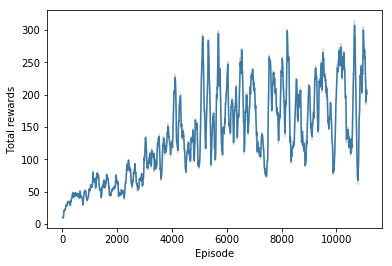

In [34]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

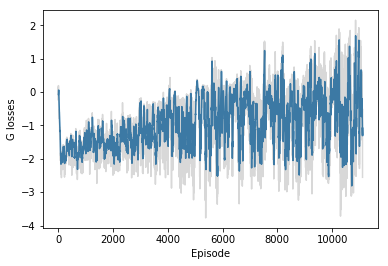

In [35]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

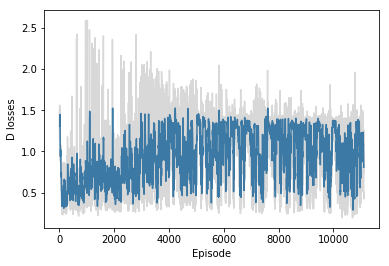

In [36]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [28]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        if total_reward == 500:
            break
                
# Closing the env
env.close()

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model2.ckpt
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.